# Local Learning Coefficient (LLC) Analysis for Reinforcement Learning Fine-tuning

This notebook implements and visualizes Local Learning Coefficient (LLC) tracking during reinforcement learning fine-tuning of transformer models.

## Research Foundation

Based on the following key papers:
1. **"The Local Learning Coefficient: A Singularity-Aware Complexity Measure"** (arxiv:2308.12108)
2. **"Differentiation and Specialization of Attention Heads via the Refined Local Learning Coefficient"** (arxiv:2410.02984)
3. **"Reinforcement Learning Finetunes Small Subnetworks in Large Language Models"** (arxiv:2505.11711)
4. **"Loss Landscape Degeneracy Drives Stagewise Development in Transformers"** (arxiv:2402.02364)

## Key Concepts

- **LLC**: Measures local complexity/degeneracy of loss landscape
- **Refined LLC**: Component-wise analysis of model parts
- **Layer-wise LLC**: Individual analysis of neural network layers
- **RL Subnetworks**: Only 5-30% of parameters change significantly during RL fine-tuning

## 1. Setup and Imports

In [13]:
# Core imports
import copy
import time
import inspect
import logging
import warnings
import numpy as np
import pandas as pd
from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union, Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Visualization imports
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output

try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Interactive plots will be disabled.")
    PLOTLY_AVAILABLE = False

%matplotlib inline

# FORCE MATPLOTLIB TO USE SAFE BACKEND
matplotlib.use('Agg')  # Use non-interactive backend

# SET GLOBAL MATPLOTLIB LIMITS
plt.rcParams['figure.max_open_warning'] = 0  # Disable max figure warning
plt.rcParams['figure.figsize'] = [10, 6]     # Set default safe figure size
plt.rcParams['savefig.dpi'] = 100            # Limit DPI to prevent huge images

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

warnings.filterwarnings('ignore', message='FigureCanvasAgg is non-interactive')
warnings.filterwarnings('ignore', message='Tight layout not applied')

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Check for CUDA
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: mps
PyTorch version: 2.7.0


## 2. Configuration and Core Classes

In [14]:
@dataclass
class Config:
    num_episode: int = 100
    d_model: int = 128*32

@dataclass
class LLCConfig:
    """FIXED configuration based on analysis of your negative LLC values"""
    # OPTIMIZED SGLD PARAMETERS (Based on your data analysis)
    temperature: float = 0.05         # Much lower for stable sampling
    sgld_steps: int = 1000            # Increased for proper convergence  
    sgld_lr: float = 2e-7            # Reduced for numerical stability
    burn_in_ratio: float = 0.95      # Longer burn-in (95% of steps)
    batch_size: int = 32             # Larger batches for stability
    epsilon: float = 1e-10           # Very small for numerical precision
    n_chains: int = 6                # More chains for reliability

    # STABILITY ENHANCEMENTS
    gradient_clip_norm: float = 0.5   # Strong gradient clipping
    noise_decay_rate: float = 0.99    # Gradually reduce noise
    min_temperature: float = 0.01     # Minimum temperature floor
    hessian_regularization: float = 1e-4  # Regularize Hessian computation
    
    # VALIDATION SETTINGS
    max_negative_tolerance: float = 1e-12  # Almost zero tolerance
    validation_enabled: bool = True        # Always validate results
    auto_retry_on_negative: bool = True    # Retry if too many negatives

# Display default configuration
default_config = LLCConfig()
print("Default LLC Configuration:")
for field, value in default_config.__dict__.items():
    print(f"  {field}: {value}")

Default LLC Configuration:
  temperature: 0.05
  sgld_steps: 1000
  sgld_lr: 2e-07
  burn_in_ratio: 0.95
  batch_size: 32
  epsilon: 1e-10
  n_chains: 6
  gradient_clip_norm: 0.5
  noise_decay_rate: 0.99
  min_temperature: 0.01
  hessian_regularization: 0.0001
  max_negative_tolerance: 1e-12
  validation_enabled: True
  auto_retry_on_negative: True


## 3. SGLD Sampler Implementation

In [15]:
class SGLDSampler:
    """
    Stochastic Gradient Langevin Dynamics sampler for LLC estimation
    Based on Welling & Teh (2011) and adapted for LLC calculation
    """
    
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.device = next(model.parameters()).device
        
    def sample(self, dataloader: DataLoader, 
               loss_fn: Callable, 
               center_params: Dict[str, torch.Tensor]) -> List[Dict[str, torch.Tensor]]:
        """
        Sample parameters using SGLD around center_params
        """
        samples = []
        loss_trace = []  # For diagnostics
        
        # Initialize model at center point
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in center_params:
                    param.copy_(center_params[name])
        
        # Create infinite dataloader iterator
        data_iter = iter(dataloader)
        
        # SGLD sampling loop
        for step in range(self.config.sgld_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                batch = next(data_iter)
            
            if isinstance(batch, (list, tuple)):
                inputs, targets = batch[0].to(self.device), batch[1].to(self.device)
            else:
                inputs, targets = batch.to(self.device), batch.to(self.device)
            
            # Compute loss and gradients
            self.model.zero_grad()
            outputs = self.model(inputs)
            
            # Handle different output formats
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs
                
            loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
            
            # Add prior term (Gaussian centered at center_params)
            prior_loss = 0.0
            for name, param in self.model.named_parameters():
                if name in center_params and param.requires_grad:
                    prior_loss += 0.5 * self.config.temperature * torch.sum(
                        (param - center_params[name])**2
                    )
            
            total_loss = loss + prior_loss
            total_loss.backward()
            
            # Store loss for diagnostics
            loss_trace.append(total_loss.item())
            
            # SGLD update with noise injection
            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        # Add gradient descent step
                        param.add_(param.grad, alpha=-self.config.sgld_lr)
                        
                        # Add Gaussian noise
                        noise_std = np.sqrt(2 * self.config.sgld_lr / self.config.temperature)
                        noise = torch.randn_like(param) * noise_std
                        param.add_(noise)
            
            # Store sample (after burn-in)
            if step >= int(self.config.sgld_steps * self.config.burn_in_ratio):
                sample = {}
                for name, param in self.model.named_parameters():
                    sample[name] = param.clone().detach()
                samples.append(sample)
        
        # Store diagnostics
        self.loss_trace = loss_trace
        
        return samples

## 4. LLC Estimator Implementation

In [16]:
class LLCEstimator:
    """
    Local Learning Coefficient estimator
    Based on "The Local Learning Coefficient: A Singularity-Aware Complexity Measure"
    """
    
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.device = next(model.parameters()).device
        
    def estimate_llc(self, dataloader: DataLoader, 
                    loss_fn: Callable,
                    center_params: Optional[Dict[str, torch.Tensor]] = None) -> Dict[str, float]:
        """
        Estimate the Local Learning Coefficient
        """
        if center_params is None:
            center_params = {name: param.clone().detach() 
                           for name, param in self.model.named_parameters()}
        
        # Sample using SGLD
        sampler = SGLDSampler(self.model, self.config)
        samples = sampler.sample(dataloader, loss_fn, center_params)
        
        if not samples:
            logger.warning("No samples collected after burn-in")
            return {"llc_mean": 0.0, "llc_std": 0.0, "n_samples": 0}
        
        # Compute loss at center point
        loss_center = self._compute_loss(dataloader, loss_fn, center_params)
        
        # Compute expected loss under perturbation
        loss_values = []
        for sample in samples:
            loss_sample = self._compute_loss(dataloader, loss_fn, sample)
            loss_values.append(loss_sample.item())
        
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values)
        
        # Compute LLC estimate using formula from paper
        # LLC_hat = (E[L(θ)] - L(θ*)) / log(n)
        n_samples = len(dataloader.dataset)
        if n_samples <= 1:
            logger.warning("Dataset too small for reliable LLC estimation")
            return {"llc_mean": 0.0, "llc_std": 0.0, "n_samples": len(samples)}
        
        llc_estimate = (loss_mean - loss_center.item()) / np.log(n_samples)
        
        # Estimate uncertainty in LLC
        loss_sem = loss_std / np.sqrt(len(loss_values))
        llc_std = loss_sem / np.log(n_samples)
        
        return {
            "llc_mean": llc_estimate,
            "llc_std": llc_std,
            "loss_center": loss_center.item(),
            "loss_perturbed_mean": loss_mean,
            "loss_perturbed_std": loss_std,
            "n_samples": len(samples),
            "sgld_trace": getattr(sampler, 'loss_trace', [])
        }
    
    def _compute_loss(self, dataloader: DataLoader, 
                     loss_fn: Callable,
                     params: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Compute loss with given parameters"""
        # Set model parameters
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in params:
                    param.copy_(params[name])
        
        self.model.eval()
        total_loss = 0.0
        n_batches = 0
        
        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, (list, tuple)):
                    inputs, targets = batch[0].to(self.device), batch[1].to(self.device)
                else:
                    inputs, targets = batch.to(self.device), batch.to(self.device)
                
                outputs = self.model(inputs)
                
                # Handle different output formats
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                elif isinstance(outputs, tuple):
                    logits = outputs[0]
                else:
                    logits = outputs
                
                loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
                total_loss += loss.item()
                n_batches += 1
        
        return torch.tensor(total_loss / n_batches if n_batches > 0 else 0.0)

## 5. Layer-wise Refined LLC Analysis System

**New Feature**: This section implements layer-wise refined LLC tracking to understand how individual neural network layers evolve during RL fine-tuning. This provides finer-grained insights than component-level analysis.

In [17]:
class LayerWiseAnalyzer:
    """
    Analyzer for identifying and categorizing model layers for refined LLC analysis
    """
    
    def __init__(self, model: nn.Module):
        self.model = model
        self.layer_groups = self._identify_layers()
    
    def _identify_layers(self) -> Dict[str, List[str]]:
        """
        Identify and categorize model layers based on parameter names and module structure
        """
        layer_groups = {
            "input_layer": [],
            "hidden_layers": [],
            "output_layer": []
        }
        
        # Analyze model structure
        for name, param in self.model.named_parameters():
            if any(x in name for x in ["embedding", "pos_encoding"]):
                layer_groups["input_layer"].append(name)
            elif "lm_head" in name:
                layer_groups["output_layer"].append(name)
            else:
                # Group transformer layers by layer number
                if "transformer.layers" in name or "encoder.layers" in name:
                    # Extract layer number and create separate groups
                    parts = name.split('.')
                    for i, part in enumerate(parts):
                        if part.isdigit():
                            layer_key = f"hidden_layer_{part}"
                            if layer_key not in layer_groups:
                                layer_groups[layer_key] = []
                            layer_groups[layer_key].append(name)
                            break
                    else:
                        layer_groups["hidden_layers"].append(name)
                else:
                    layer_groups["hidden_layers"].append(name)
        
        # Clean up empty groups
        layer_groups = {k: v for k, v in layer_groups.items() if v}
        
        return layer_groups
    
    def get_layer_info(self) -> Dict[str, Dict]:
        """
        Get detailed information about each layer group
        """
        layer_info = {}
        
        for layer_name, param_names in self.layer_groups.items():
            total_params = 0
            param_shapes = []
            
            for param_name in param_names:
                for name, param in self.model.named_parameters():
                    if name == param_name:
                        total_params += param.numel()
                        param_shapes.append(f"{name}: {param.shape}")
            
            layer_info[layer_name] = {
                "param_count": total_params,
                "param_names": param_names,
                "param_shapes": param_shapes
            }
        
        return layer_info
    
    def print_layer_analysis(self):
        """
        Print detailed layer analysis
        """
        print("Layer-wise Model Analysis:")
        print("=" * 50)
        
        layer_info = self.get_layer_info()
        total_params = sum(info["param_count"] for info in layer_info.values())
        
        for layer_name, info in layer_info.items():
            percentage = (info["param_count"] / total_params) * 100
            print(f"\n{layer_name}:")
            print(f"  Parameters: {info['param_count']:,} ({percentage:.1f}%)")
            print(f"  Components: {len(info['param_names'])}")
            for shape in info["param_shapes"]:
                print(f"    {shape}")
        
        print(f"\nTotal Parameters: {total_params:,}")

In [18]:
class ComponentSGLDSampler:
    """
    SGLD sampler that only perturbs specific component parameters
    """
    
    def __init__(self, model: nn.Module, config: LLCConfig, component_params: Dict[str, torch.Tensor]):
        self.model = model
        self.config = config
        self.component_params = set(component_params.keys())
        self.device = next(model.parameters()).device
    
    def sample(self, dataloader: DataLoader,
               loss_fn: Callable,
               center_params: Dict[str, torch.Tensor]) -> List[Dict[str, torch.Tensor]]:
        """Sample only component parameters while keeping others fixed"""
        samples = []
        
        # Initialize model at center point
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in center_params:
                    param.copy_(center_params[name])
        
        data_iter = iter(dataloader)
        
        # SGLD sampling loop
        for step in range(self.config.sgld_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(dataloader)
                batch = next(data_iter)
            
            if isinstance(batch, (list, tuple)):
                inputs, targets = batch[0].to(self.device), batch[1].to(self.device)
            else:
                inputs, targets = batch.to(self.device), batch.to(self.device)
            
            self.model.zero_grad()
            outputs = self.model(inputs)
            
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            elif isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs
                
            loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
            
            # Add prior term only for component parameters
            prior_loss = 0.0
            for name, param in self.model.named_parameters():
                if name in self.component_params and name in center_params:
                    prior_loss += 0.5 * self.config.temperature * torch.sum(
                        (param - center_params[name])**2
                    )
            
            total_loss = loss + prior_loss
            total_loss.backward()
            
            # SGLD update only for component parameters
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    if name in self.component_params and param.grad is not None:
                        # Gradient descent step
                        param.add_(param.grad, alpha=-self.config.sgld_lr)
                        
                        # Add Gaussian noise
                        noise_std = np.sqrt(2 * self.config.sgld_lr / self.config.temperature)
                        noise = torch.randn_like(param) * noise_std
                        param.add_(noise)
            
            # Store sample after burn-in
            if step >= int(self.config.sgld_steps * self.config.burn_in_ratio):
                sample = {name: param.clone().detach() 
                         for name, param in self.model.named_parameters()}
                samples.append(sample)
        
        return samples

In [19]:
class LayerWiseRefinedLLCEstimator:
    """
    Enhanced refined LLC estimator that operates on individual layers
    """
    
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.device = next(model.parameters()).device
        self.layer_analyzer = LayerWiseAnalyzer(model)
        
    def estimate_layer_wise_llc(self, dataloader: DataLoader,
                               loss_fn: Callable,
                               center_params: Optional[Dict[str, torch.Tensor]] = None) -> Dict[str, Dict[str, float]]:
        """
        Estimate refined LLC for each individual layer
        """
        if center_params is None:
            center_params = {name: param.clone().detach() 
                           for name, param in self.model.named_parameters()}
        
        results = {}
        layer_groups = self.layer_analyzer.layer_groups
        
        for layer_name, param_names in layer_groups.items():
            logger.info(f"Estimating layer-wise LLC for: {layer_name}")
            
            if not param_names:
                logger.warning(f"No parameters found for layer {layer_name}")
                continue
            
            # Create parameter dictionary for this layer
            layer_params = {name: center_params[name] for name in param_names if name in center_params}
            
            if not layer_params:
                logger.warning(f"No matching parameters for layer {layer_name}")
                continue
            
            # Estimate LLC for this layer
            llc_result = self._estimate_single_layer_llc(
                dataloader, loss_fn, layer_params, center_params, layer_name
            )
            results[layer_name] = llc_result
        
        return results
    
    def _estimate_single_layer_llc(self, dataloader: DataLoader,
                                  loss_fn: Callable,
                                  layer_params: Dict[str, torch.Tensor],
                                  center_params: Dict[str, torch.Tensor],
                                  layer_name: str) -> Dict[str, float]:
        """Estimate LLC for a single layer"""
        
        # Use component SGLD sampler for this layer
        sampler = ComponentSGLDSampler(self.model, self.config, layer_params)
        samples = sampler.sample(dataloader, loss_fn, center_params)
        
        if not samples:
            return {
                "llc_mean": 0.0, 
                "llc_std": 0.0, 
                "n_samples": 0,
                "layer_param_count": len(layer_params)
            }
        
        # Compute loss at center point
        loss_center = self._compute_loss(dataloader, loss_fn, center_params)
        
        # Compute expected loss under layer perturbation
        loss_values = []
        for sample in samples:
            loss_sample = self._compute_loss(dataloader, loss_fn, sample)
            loss_values.append(loss_sample.item())
        
        loss_mean = np.mean(loss_values)
        loss_std = np.std(loss_values)
        
        # Compute layer-wise LLC
        n_samples = len(dataloader.dataset)
        if n_samples <= 1:
            return {
                "llc_mean": 0.0, 
                "llc_std": 0.0, 
                "n_samples": len(samples),
                "layer_param_count": len(layer_params)
            }
        
        llc_estimate = (loss_mean - loss_center.item()) / np.log(n_samples)
        loss_sem = loss_std / np.sqrt(len(loss_values))
        llc_std = loss_sem / np.log(n_samples)
        
        return {
            "llc_mean": llc_estimate,
            "llc_std": llc_std,
            "loss_center": loss_center.item(),
            "loss_perturbed_mean": loss_mean,
            "loss_perturbed_std": loss_std,
            "n_samples": len(samples),
            "layer_param_count": len(layer_params)
        }
    
    def _compute_loss(self, dataloader: DataLoader,
                     loss_fn: Callable,
                     params: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Compute loss with given parameters"""
        # Set model parameters
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in params:
                    param.copy_(params[name])
        
        self.model.eval()
        total_loss = 0.0
        n_batches = 0
        
        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, (list, tuple)):
                    inputs, targets = batch[0].to(self.device), batch[1].to(self.device)
                else:
                    inputs, targets = batch.to(self.device), batch.to(self.device)
                
                outputs = self.model(inputs)
                
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                elif isinstance(outputs, tuple):
                    logits = outputs[0]
                else:
                    logits = outputs
                
                loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
                total_loss += loss.item()
                n_batches += 1
        
        return torch.tensor(total_loss / n_batches if n_batches > 0 else 0.0)

## 6. Enhanced RL LLC Tracker with Layer-wise Analysis

In [20]:
class EnhancedRLLLCTracker:
    """
    Enhanced tracker with layer-wise refined LLC analysis
    """
    
    def __init__(self, model: nn.Module, config: LLCConfig):
        self.model = model
        self.config = config
        self.llc_estimator = LLCEstimator(model, config)
        self.layer_wise_estimator = LayerWiseRefinedLLCEstimator(model, config)
        self.layer_analyzer = LayerWiseAnalyzer(model)
        
        # Define component groups
        self.component_groups = {
            "input_embeddings": ["embedding.weight"],
            "position_embeddings": ["pos_encoding"],
            "attention_combined": ["in_proj_weight", "in_proj_bias"],
            "attention_output": ["out_proj"],
            "mlp_intermediate": ["linear1"],
            "mlp_output": ["linear2"],
            "layer_norm_1": ["norm1"],
            "layer_norm_2": ["norm2"],
            "final_layer_norm": ["ln_f"],
            "output_layer": ["lm_head"]
        }
        
        # Storage for data
        self.episode_history = []
        self.reward_history = []
        self.layer_wise_history = []
        
    def track_episode(self, episode: int, 
                     dataloader: DataLoader,
                     loss_fn: Callable,
                     reward: float = None,
                     track_components: bool = True,
                     track_layers: bool = True) -> Dict[str, any]:
        """
        Enhanced episode tracking with layer-wise analysis
        """
        logger.info(f"Computing enhanced LLC for RL episode {episode}")
        start_time = time.time()
        
        # Get current model parameters as center point
        center_params = {name: param.clone().detach() 
                        for name, param in self.model.named_parameters() 
                        if param.requires_grad}
        
        # Compute overall LLC
        overall_llc = self.llc_estimator.estimate_llc(dataloader, loss_fn, center_params)
        
        results = {
            "episode": episode,
            "overall_llc": overall_llc,
            "reward": reward,
            "computation_time": time.time() - start_time
        }
        
        # Compute layer-wise refined LLC
        if track_layers:
            layer_wise_llc = self.layer_wise_estimator.estimate_layer_wise_llc(
                dataloader, loss_fn, center_params
            )
            results["layer_wise_llc"] = layer_wise_llc
            self.layer_wise_history.append({
                "episode": episode,
                "layer_llc": layer_wise_llc,
                "reward": reward
            })
        
        # Store in history
        self.episode_history.append(results)
        if reward is not None:
            self.reward_history.append(reward)
        
        results["computation_time"] = time.time() - start_time
        return results
    
    def get_layer_wise_evolution(self) -> Dict[str, List[float]]:
        """Get the evolution of layer-wise LLC values across episodes"""
        if not self.layer_wise_history:
            return {}
        
        evolution = {
            "episodes": [h["episode"] for h in self.layer_wise_history],
            "rewards": [h.get("reward", 0) for h in self.layer_wise_history]
        }
        
        # Extract layer data
        if self.layer_wise_history:
            first_episode = self.layer_wise_history[0]
            layer_names = list(first_episode["layer_llc"].keys())
            
            for layer_name in layer_names:
                evolution[f"{layer_name}_llc_mean"] = []
                evolution[f"{layer_name}_llc_std"] = []
                evolution[f"{layer_name}_param_count"] = []
                
                for h in self.layer_wise_history:
                    if layer_name in h["layer_llc"]:
                        evolution[f"{layer_name}_llc_mean"].append(
                            h["layer_llc"][layer_name]["llc_mean"]
                        )
                        evolution[f"{layer_name}_llc_std"].append(
                            h["layer_llc"][layer_name]["llc_std"]
                        )
                        evolution[f"{layer_name}_param_count"].append(
                            h["layer_llc"][layer_name].get("layer_param_count", 0)
                        )
                    else:
                        evolution[f"{layer_name}_llc_mean"].append(0.0)
                        evolution[f"{layer_name}_llc_std"].append(0.0)
                        evolution[f"{layer_name}_param_count"].append(0)
        
        return evolution
    
    def get_llc_evolution(self) -> Dict[str, List[float]]:
        """Get the evolution of overall LLC values"""
        if not self.episode_history:
            return {}
        
        evolution = {
            "episodes": [h["episode"] for h in self.episode_history],
            "overall_llc_mean": [h["overall_llc"]["llc_mean"] for h in self.episode_history],
            "overall_llc_std": [h["overall_llc"]["llc_std"] for h in self.episode_history],
            "rewards": [h.get("reward", 0) for h in self.episode_history]
        }
        
        return evolution
    
    def analyze_layer_activity(self) -> Dict[str, any]:
        """
        Analyze which layers are most active during RL fine-tuning
        """
        if not self.layer_wise_history:
            logger.warning("No layer-wise LLC data available for analysis")
            return {}
        
        layer_evolution = self.get_layer_wise_evolution()
        layer_variance = {}
        layer_mean_llc = {}
        layer_param_counts = {}
        
        # Calculate variance and mean for each layer
        for key, values in layer_evolution.items():
            if key.endswith('_llc_mean'):
                layer_name = key.replace('_llc_mean', '')
                if values and any(abs(v) > 1e-8 for v in values):
                    layer_variance[layer_name] = np.var(values)
                    layer_mean_llc[layer_name] = np.mean(values)
        
        # Get parameter counts
        if self.layer_wise_history:
            latest_data = self.layer_wise_history[-1]["layer_llc"]
            for layer_name, data in latest_data.items():
                layer_param_counts[layer_name] = data.get("layer_param_count", 0)
        
        # Rank layers by activity (variance)
        active_layers = sorted(layer_variance.items(), 
                              key=lambda x: x[1], reverse=True)
        
        return {
            "layer_variance": layer_variance,
            "layer_mean_llc": layer_mean_llc,
            "layer_param_counts": layer_param_counts,
            "most_active_layers": active_layers[:5],
            "least_active_layers": active_layers[-3:] if len(active_layers) >= 3 else []
        }
    
    def detect_phase_transitions(self, threshold: float = 0.1) -> List[Dict]:
        """
        Detect phase transitions in LLC evolution
        """
        if len(self.episode_history) < 3:
            return []
        
        llc_values = [h["overall_llc"]["llc_mean"] for h in self.episode_history]
        episodes = [h["episode"] for h in self.episode_history]
        
        transitions = []
        
        for i in range(1, len(llc_values) - 1):
            # Compute local rate of change
            prev_change = llc_values[i] - llc_values[i-1]
            next_change = llc_values[i+1] - llc_values[i]
            
            # Detect significant change in derivative (potential phase transition)
            if abs(next_change - prev_change) > threshold:
                transitions.append({
                    "episode": episodes[i],
                    "llc_value": llc_values[i],
                    "change_magnitude": abs(next_change - prev_change),
                    "transition_type": "increase" if next_change > prev_change else "decrease"
                })
        
        return transitions

## 7. Enhanced Visualization Functions

In [21]:
def safe_figure(figsize=(10, 6), dpi=100):
    """Create a figure with size safety checks"""
    # Enforce maximum dimensions
    MAX_WIDTH = 20   # Maximum width in inches
    MAX_HEIGHT = 15  # Maximum height in inches
    MIN_DPI = 50     # Minimum DPI
    MAX_DPI = 150    # Maximum DPI
    
    # Clamp figsize to safe limits
    safe_width = max(1, min(figsize[0], MAX_WIDTH))
    safe_height = max(1, min(figsize[1], MAX_HEIGHT))
    safe_dpi = max(MIN_DPI, min(dpi, MAX_DPI))
    
    # Calculate pixel dimensions and check limits
    pixel_width = safe_width * safe_dpi
    pixel_height = safe_height * safe_dpi
    
    # Matplotlib limit is 2^16 = 65536 pixels
    MAX_PIXELS = 32768  # Use half the limit for safety
    
    if pixel_width > MAX_PIXELS or pixel_height > MAX_PIXELS:
        # Scale down proportionally
        scale = min(MAX_PIXELS / pixel_width, MAX_PIXELS / pixel_height)
        safe_width = safe_width * scale
        safe_height = safe_height * scale
        print(f"⚠️ Figure size scaled down to prevent matplotlib error: {safe_width:.1f}x{safe_height:.1f}")
    
    return plt.figure(figsize=(safe_width, safe_height), dpi=safe_dpi)

def safe_subplots(nrows=1, ncols=1, figsize=(10, 6), **kwargs):
    """Create subplots with size safety checks and proper spacing"""
    
    # Safe figure size limits
    max_width = min(figsize[0], 16)
    max_height = min(figsize[1], 12) 
    safe_figsize = (max_width, max_height)
    
    # Create figure with manual spacing instead of tight_layout
    fig, axes = plt.subplots(nrows, ncols, figsize=safe_figsize, **kwargs)
    
    # Apply manual spacing to prevent tight_layout warnings
    fig.subplots_adjust(
        left=0.08,    # Left margin
        bottom=0.12,  # Bottom margin (more space for x-labels)
        right=0.95,   # Right margin  
        top=0.88,     # Top margin (space for suptitle)
        wspace=0.3,   # Width spacing between subplots
        hspace=0.4    # Height spacing between subplots
    )
    
    return fig, axes

# 4. REPLACE YOUR PROBLEMATIC PLOTTING CODE WITH THIS SAFE VERSION
def plot_layer_analysis_dashboard_SAFE(figsize=(18, 12), save_path=None):
    """SAFE version of plot_layer_analysis_dashboard"""
    
    print("📈 Creating layer analysis dashboard with size safety...")
    
    # Use safe subplot creation
    fig, axes = safe_subplots(2, 3, figsize=figsize)
    fig.suptitle('Layer-wise LLC Analysis Dashboard', fontsize=14, fontweight='bold')
    
    # Flatten axes for easier access
    axes = axes.flatten()
    
    # Generate sample data for demonstration
    episodes = np.arange(1, 101)
    
    # Plot 1: Layer activations
    activations = np.random.normal(0.5, 0.1, 100).cumsum() * 0.01
    axes[0].plot(episodes, activations, 'b-', linewidth=2)
    axes[0].set_title('Layer Activations', fontsize=12)
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Activation')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Gradient flow
    gradients = np.random.exponential(0.1, 100)
    axes[1].plot(episodes, gradients, 'r-', linewidth=2)
    axes[1].set_title('Gradient Flow', fontsize=12)
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Gradient Norm')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Weight changes
    weights = np.random.normal(0, 0.05, 100).cumsum()
    axes[2].plot(episodes, weights, 'g-', linewidth=2)
    axes[2].set_title('Weight Changes', fontsize=12)
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Weight Delta')
    axes[2].grid(True, alpha=0.3)
    
    # Plot 4: Rewards
    rewards = np.random.normal(0.1, 0.05, 100).cumsum()
    axes[3].plot(episodes, rewards, 'm-', linewidth=2)
    axes[3].set_title('Layer Rewards', fontsize=12)
    axes[3].set_xlabel('Episode')
    axes[3].set_ylabel('Reward')
    axes[3].grid(True, alpha=0.3)
    
    # Plot 5: Attention heatmap (small size to prevent issues)
    attention_data = np.random.rand(8, 8)  # Small 8x8 instead of large matrix
    im = axes[4].imshow(attention_data, cmap='viridis', aspect='auto')
    axes[4].set_title('Attention Patterns', fontsize=12)
    plt.colorbar(im, ax=axes[4], shrink=0.6)
    
    # Plot 6: Complexity
    complexity = np.random.uniform(0.3, 0.8, 100)
    axes[5].plot(episodes, complexity, 'c-', linewidth=2)
    axes[5].set_title('Layer Complexity', fontsize=12)
    axes[5].set_xlabel('Episode')
    axes[5].set_ylabel('Complexity')
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')  # Safe DPI
        print(f"📊 Dashboard saved to {save_path}")
    
    plt.show()
    plt.close(fig)  # Always close to prevent memory issues
    print("✅ Dashboard created successfully!")

# 5. EMERGENCY MATPLOTLIB RESET FUNCTION
def reset_matplotlib():
    """Reset matplotlib to safe defaults"""
    plt.close('all')  # Close all existing figures
    matplotlib.rcdefaults()  # Reset to defaults
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 100
    print("🔄 Matplotlib reset to safe defaults")


In [22]:
class EnhancedLLCVisualizer:
    """
    Enhanced visualization toolkit with layer-wise analysis capabilities
    """
    
    def __init__(self, tracker: EnhancedRLLLCTracker):
        self.tracker = tracker
        
    def plot_layer_wise_evolution(self, figsize=(16, 12), save_path=None):
        """Plot layer-wise LLC evolution over episodes"""
        
        layer_evolution = self.tracker.get_layer_wise_evolution()
        
        if not layer_evolution or len(layer_evolution.get("episodes", [])) == 0:
            print("No layer-wise data available for plotting")
            return
        
        # Extract layer names
        layer_names = [key.replace('_llc_mean', '') for key in layer_evolution.keys() 
                    if key.endswith('_llc_mean')]
        
        if not layer_names:
            print("No layer LLC data found")
            return
        
        # Create subplots with safe sizing
        n_layers = len(layer_names)
        n_cols = min(3, n_layers + 1)
        n_rows = (n_layers + 2) // n_cols
        
        # Ensure reasonable figure size
        safe_width = min(figsize[0], 16)
        safe_height = min(figsize[1], 12)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(safe_width, safe_height))
        
        # Manual spacing instead of tight_layout
        fig.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.90, wspace=0.3, hspace=0.4)
        
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        fig.suptitle('Layer-wise Refined LLC Evolution', fontsize=14, fontweight='bold')
        
        episodes = layer_evolution['episodes']
        colors = plt.cm.Set1(np.linspace(0, 1, len(layer_names)))
        
        # Rest of your plotting code remains the same...
        for i, layer_name in enumerate(layer_names):
            if i < len(axes) - 1:
                ax = axes[i]
                
                llc_mean = layer_evolution[f'{layer_name}_llc_mean']
                llc_std = layer_evolution[f'{layer_name}_llc_std']
                
                if any(abs(v) > 1e-6 for v in llc_mean):
                    ax.errorbar(episodes, llc_mean, yerr=llc_std, 
                            color=colors[i], marker='o', capsize=3, 
                            linewidth=2, markersize=4, label=layer_name)
                    
                    ax.set_xlabel('Episode', fontsize=10)
                    ax.set_ylabel('Layer LLC', fontsize=10)
                    ax.set_title(f'{layer_name.replace("_", " ").title()}', fontsize=11)
                    ax.grid(True, alpha=0.3)
                    
                    param_count = layer_evolution[f'{layer_name}_param_count'][0] if layer_evolution[f'{layer_name}_param_count'] else 0
                    ax.text(0.02, 0.98, f'Params: {param_count:,}', 
                        transform=ax.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                        fontsize=8)
                else:
                    ax.text(0.5, 0.5, f'{layer_name}\n(No significant changes)', 
                        ha='center', va='center', transform=ax.transAxes, fontsize=10)
                    ax.set_title(f'{layer_name.replace("_", " ").title()}', fontsize=11)
        
        # Summary plot
        if len(axes) > len(layer_names):
            summary_ax = axes[len(layer_names)]
            
            for i, layer_name in enumerate(layer_names):
                llc_mean = layer_evolution[f'{layer_name}_llc_mean']
                if any(abs(v) > 1e-6 for v in llc_mean):
                    summary_ax.plot(episodes, llc_mean, color=colors[i], 
                                marker='o', linewidth=2, markersize=3, 
                                label=layer_name.replace('_', ' '))
            
            summary_ax.set_xlabel('Episode', fontsize=10)
            summary_ax.set_ylabel('Layer LLC', fontsize=10)
            summary_ax.set_title('All Layers Comparison', fontsize=11)
            summary_ax.legend(fontsize=8, loc='best')
            summary_ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(layer_names) + 1, len(axes)):
            axes[i].set_visible(False)
        
        # DON'T use plt.tight_layout() - we already set spacing manually
        
        if save_path:
            try:
                plt.savefig(save_path, dpi=150, bbox_inches='tight')
            except Exception as e:
                print(f"Could not save figure: {e}")
        
        plt.show()
        plt.close(fig)
    
    def plot_layer_analysis_dashboard(self, figsize=(18, 12), save_path=None):
        """Create comprehensive layer analysis dashboard"""
        
        layer_evolution = self.tracker.get_layer_wise_evolution()
        layer_analysis = self.tracker.analyze_layer_activity()
        
        if not layer_evolution:
            print("No layer-wise data available")
            return

        # Safe figure size
        safe_width = min(figsize[0], 16)
        safe_height = min(figsize[1], 10)
        
        fig, axes = plt.subplots(2, 3, figsize=(safe_width, safe_height))
        
        # Manual spacing instead of tight_layout
        fig.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.88, wspace=0.3, hspace=0.4)
        
        fig.suptitle('Layer-wise LLC Analysis Dashboard', fontsize=14, fontweight='bold')
        
        # Rest of your plotting code...
        episodes = layer_evolution.get('episodes', [])
        
        # Plot 1: Layer LLC Evolution
        ax1 = axes[0, 0]
        main_layers = ['input_layer', 'hidden_layers', 'output_layer']
        colors = ['blue', 'green', 'red']
        
        for i, layer in enumerate(main_layers):
            if f'{layer}_llc_mean' in layer_evolution:
                llc_values = layer_evolution[f'{layer}_llc_mean']
                if any(abs(v) > 1e-6 for v in llc_values):
                    ax1.plot(episodes, llc_values, color=colors[i], 
                        marker='o', linewidth=2, label=layer.replace('_', ' '))
        
        ax1.set_xlabel('Episode', fontsize=10)
        ax1.set_ylabel('LLC', fontsize=10)
        ax1.set_title('Main Layer LLC Evolution', fontsize=11)
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Continue with your other plots...
        # (Keep the rest of your plotting code but remove plt.tight_layout())
        
        # Replace plt.tight_layout() with nothing (we already set spacing)
        
        if save_path:
            try:
                plt.savefig(save_path, dpi=150, bbox_inches='tight')
            except Exception as e:
                print(f"Could not save figure: {e}")
        
        plt.show()
        plt.close(fig)

    # EnhancedLLCVisualizerクラスにメソッドを動的に追加
    def create_layer_summary(self):
        """Create a comprehensive layer analysis summary"""
        
        if not hasattr(self.tracker, 'layer_wise_history') or not self.tracker.layer_wise_history:
            print("No layer-wise data available for summary")
            return
        
        layer_evolution = self.tracker.get_layer_wise_evolution()
        layer_analysis = self.tracker.analyze_layer_activity()
        
        print("=" * 70)
        print("                    LAYER-WISE LLC ANALYSIS SUMMARY")
        print("=" * 70)
        
        print(f"\nData Overview:")
        print(f"  Episodes analyzed: {len(layer_evolution.get('episodes', []))}")
        
        if layer_analysis:
            print(f"  Layers tracked: {len(layer_analysis.get('layer_param_counts', {}))}")
            
            print(f"\nLayer Parameter Distribution:")
            param_counts = layer_analysis.get('layer_param_counts', {})
            total_params = sum(param_counts.values()) if param_counts else 0
            
            for layer, count in sorted(param_counts.items(), key=lambda x: x[1], reverse=True):
                percentage = (count / total_params) * 100 if total_params > 0 else 0
                print(f"  {layer:<20}: {count:>8,} params ({percentage:5.1f}%)")
            
            print(f"\nMost Active Layers (by LLC variance):")
            active_layers = layer_analysis.get('most_active_layers', [])
            for i, (layer, variance) in enumerate(active_layers[:5], 1):
                mean_llc = layer_analysis.get('layer_mean_llc', {}).get(layer, 0)
                print(f"  {i}. {layer:<20}: variance={variance:.6f}, mean_LLC={mean_llc:.4f}")
            
            print(f"\nLeast Active Layers:")
            least_active = layer_analysis.get('least_active_layers', [])
            for i, (layer, variance) in enumerate(least_active[:5], 1):
                mean_llc = layer_analysis.get('layer_mean_llc', {}).get(layer, 0)
                print(f"  {i}. {layer:<20}: variance={variance:.6f}, mean_LLC={mean_llc:.4f}")
        
        print("\n" + "=" * 70)


## 8. Enhanced Model Analysis with Layer-wise Tracking

This section demonstrates the new layer-wise refined LLC tracking capabilities. This provides deeper insights into how individual neural network layers evolve during RL fine-tuning.

In [23]:
class SimpleTransformer(nn.Module):
    """Simple transformer model for demonstration"""
    
    def __init__(self, vocab_size: int = 1000, d_model: int = 128, nhead: int = 4, num_layers: int = 2):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model) * 0.1)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        seq_len = x.size(1)
        # Token + positional embeddings
        x = self.embedding(x) + self.pos_encoding[:seq_len]
        # Transformer layers
        x = self.transformer(x)
        # Final layer norm
        x = self.ln_f(x)
        # Language modeling head
        return self.lm_head(x)

# Create model instance with layer analysis
model = SimpleTransformer(vocab_size=1000, d_model=Config.d_model, nhead=4, num_layers=2).to(device)

print(f"Model Statistics:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Analyze the layer structure
layer_analyzer = LayerWiseAnalyzer(model)
layer_analyzer.print_layer_analysis()

print(f"\nLayer Groups for Tracking:")
for layer_name, param_names in layer_analyzer.layer_groups.items():
    print(f"  {layer_name}: {len(param_names)} parameters")
    for param_name in param_names[:3]:  # Show first 3
        print(f"    - {param_name}")
    if len(param_names) > 3:
        print(f"    ... and {len(param_names) - 3} more")

Model Statistics:
  Total parameters: 415,056,872
  Trainable parameters: 415,056,872
Layer-wise Model Analysis:

input_layer:
  Parameters: 8,192,000 (2.0%)
  Components: 2
    pos_encoding: torch.Size([1000, 4096])
    embedding.weight: torch.Size([1000, 4096])

hidden_layers:
  Parameters: 8,192 (0.0%)
  Components: 2
    ln_f.weight: torch.Size([4096])
    ln_f.bias: torch.Size([4096])

output_layer:
  Parameters: 4,097,000 (1.0%)
  Components: 2
    lm_head.weight: torch.Size([1000, 4096])
    lm_head.bias: torch.Size([1000])

hidden_layer_0:
  Parameters: 201,379,840 (48.5%)
  Components: 12
    transformer.layers.0.self_attn.in_proj_weight: torch.Size([12288, 4096])
    transformer.layers.0.self_attn.in_proj_bias: torch.Size([12288])
    transformer.layers.0.self_attn.out_proj.weight: torch.Size([4096, 4096])
    transformer.layers.0.self_attn.out_proj.bias: torch.Size([4096])
    transformer.layers.0.linear1.weight: torch.Size([16384, 4096])
    transformer.layers.0.linear1.bia

## 9. Enhanced Data Generation and Tracking Setup

Now we'll set up the enhanced tracking system with layer-wise analysis capabilities.

In [24]:
# Create sample data
def create_sample_data(n_samples=200, seq_len=32, vocab_size=1000):
    """
    Create sample training data for demonstration
    """
    # Generate random sequences
    inputs = torch.randint(0, vocab_size, (n_samples, seq_len))
    # Targets are inputs shifted by 1 (standard language modeling)
    targets = torch.cat([inputs[:, 1:], torch.randint(0, vocab_size, (n_samples, 1))], dim=1)
    
    return TensorDataset(inputs, targets)

# Create datasets
train_dataset = create_sample_data(n_samples=200, seq_len=32)
val_dataset = create_sample_data(n_samples=50, seq_len=32)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Create LLC configuration with reduced parameters for demo
config = LLCConfig(
    temperature=1.0,
    sgld_steps=100,  # Reduced for demo to prevent long computation
    sgld_lr=1e-6,
    burn_in_ratio=0.8,
    batch_size=8,  # Smaller batch size for demo
    n_chains=2  
)

print(f"\nLLC Configuration:")
for field, value in config.__dict__.items():
    print(f"  {field}: {value}")

# Initialize the enhanced tracking system
enhanced_tracker = EnhancedRLLLCTracker(model, config)
enhanced_visualizer = EnhancedLLCVisualizer(enhanced_tracker)

print(f"\nEnhanced Tracking System Initialized:")
print("=" * 40)

print(f"\nLayer Groups:")
for layer_name, param_list in enhanced_tracker.layer_analyzer.layer_groups.items():
    print(f"  {layer_name}: {len(param_list)} parameters")

print("\nEnhanced tracker ready for layer-wise LLC analysis!")

Training data: 200 samples
Validation data: 50 samples

LLC Configuration:
  temperature: 1.0
  sgld_steps: 100
  sgld_lr: 1e-06
  burn_in_ratio: 0.8
  batch_size: 8
  epsilon: 1e-10
  n_chains: 2
  gradient_clip_norm: 0.5
  noise_decay_rate: 0.99
  min_temperature: 0.01
  hessian_regularization: 0.0001
  max_negative_tolerance: 1e-12
  validation_enabled: True
  auto_retry_on_negative: True

Enhanced Tracking System Initialized:

Layer Groups:
  input_layer: 2 parameters
  hidden_layers: 2 parameters
  output_layer: 2 parameters
  hidden_layer_0: 12 parameters
  hidden_layer_1: 12 parameters

Enhanced tracker ready for layer-wise LLC analysis!


## 10. Enhanced RL Training Simulation with Layer-wise Tracking

This section demonstrates the enhanced RL training simulation with comprehensive layer-wise LLC tracking.

In [25]:
# Enhanced simulation function with layer tracking
def simulate_enhanced_rl_training(tracker, num_episodes=5, track_components=True, track_layers=True):
    """
    Enhanced simulation with layer-wise LLC tracking
    """
    print("Starting Enhanced RL Training Simulation")
    print("=" * 50)
    print(f"Features enabled:")
    print(f"  - Overall LLC tracking: ✓")
    print(f"  - Component LLC tracking: {'✓' if track_components else '✗'}")
    print(f"  - Layer-wise LLC tracking: {'✓' if track_layers else '✗'}")
    print("=" * 50)
    
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    for episode in range(num_episodes):
        episode_start = time.time()
        print(f"\n📊 Episode {episode + 1}/{num_episodes}")
        print("-" * 30)
        
        # Simulate parameter updates
        model.train()
        total_loss = 0
        
        for i, (inputs, targets) in enumerate(train_dataloader):
            if i >= 2:  # Just a few steps for simulation
                break
                
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            
            # Add RL-style noise
            with torch.no_grad():
                for param in model.parameters():
                    if param.grad is not None:
                        noise = torch.randn_like(param) * 0.001 * (1 + episode * 0.1)
                        param.grad.add_(noise)
            
            optimizer.step()
            total_loss += loss.item()
        
        # Simulate reward
        base_reward = 0.5 + episode * 0.05
        reward = base_reward + np.random.normal(0, 0.1)
        
        print(f"Training loss: {total_loss/2:.4f}")
        print(f"Simulated reward: {reward:.4f}")
        
        # Enhanced LLC tracking
        print(f"Computing enhanced LLC analysis... ", end="", flush=True)
        llc_start = time.time()
        
        results = tracker.track_episode(
            episode=episode,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            reward=reward,
            track_components=track_components,
            track_layers=track_layers
        )
        
        llc_time = time.time() - llc_start
        print(f"({llc_time:.1f}s)")
        
        # Display results
        print(f"\n📈 Results:")
        print(f"  Overall LLC: {results['overall_llc']['llc_mean']:.4f} ± {results['overall_llc']['llc_std']:.4f}")
        
        # Show layer results
        if 'layer_wise_llc' in results:
            valid_layers = {k: v for k, v in results['layer_wise_llc'].items() 
                           if abs(v['llc_mean']) > 1e-6}
            if valid_layers:
                print(f"  Layer-wise LLC:")
                sorted_layers = sorted(valid_layers.items(), 
                                     key=lambda x: abs(x[1]['llc_mean']), reverse=True)
                for layer_name, layer_data in sorted_layers[:3]:
                    param_count = layer_data.get('layer_param_count', 0)
                    print(f"    {layer_name}: {layer_data['llc_mean']:.4f} ({param_count:,} params)")
        
        episode_time = time.time() - episode_start
        print(f"\n⏱️  Episode completed in {episode_time:.1f}s")
        
        # Progress indicator
        progress = (episode + 1) / num_episodes * 100
        elapsed = time.time() - start_time
        eta = elapsed / (episode + 1) * (num_episodes - episode - 1)
        print(f"Progress: {progress:.0f}% | ETA: {eta:.0f}s")
    
    total_time = time.time() - start_time
    print("\n" + "=" * 50)
    print(f"✅ Enhanced simulation completed in {total_time:.1f}s!")
    print(f"Average time per episode: {total_time/num_episodes:.1f}s")
    return tracker

# Run the enhanced simulation
print("🚀 Starting enhanced RL training simulation...")
enhanced_tracker = simulate_enhanced_rl_training(
    enhanced_tracker, 
    num_episodes=Config.num_episode,
    track_components=True, 
    track_layers=True
)

🚀 Starting enhanced RL training simulation...
Starting Enhanced RL Training Simulation
Features enabled:
  - Overall LLC tracking: ✓
  - Component LLC tracking: ✓
  - Layer-wise LLC tracking: ✓

📊 Episode 1/100
------------------------------
Training loss: 7.0933
Simulated reward: 0.4826
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 0
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(100.2s)

📈 Results:
  Overall LLC: 0.0963 ± 0.0025
  Layer-wise LLC:
    output_layer: 0.1096 (2 params)
    hidden_layer_1: 0.0032 (12 params)
    hidden_layer_0: -0.0005 (12 params)

⏱️  Episode completed in 101.5s
Progress: 1% | ETA: 10108s

📊 Episode 2/100
------------------------------
Training loss: 6.9637
Simulated reward: 0.6454
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 1
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(96.6s)

📈 Results:
  Overall LLC: 0.1043 ± 0.0018
  Layer-wise LLC:
    output_layer: 0.0863 (2 params)
    hidden_layer_1: -0.0034 (12 params)
    hidden_layer_0: 0.0025 (12 params)

⏱️  Episode completed in 99.4s
Progress: 2% | ETA: 9871s

📊 Episode 3/100
------------------------------
Training loss: 7.0488
Simulated reward: 0.4729
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 2
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.4s)

📈 Results:
  Overall LLC: 0.0848 ± 0.0008
  Layer-wise LLC:
    output_layer: 0.0995 (2 params)
    hidden_layer_1: -0.0100 (12 params)
    hidden_layer_0: -0.0019 (12 params)

⏱️  Episode completed in 111.1s
Progress: 3% | ETA: 10105s

📊 Episode 4/100
------------------------------
Training loss: 6.9955
Simulated reward: 0.6244
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 3
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(111.8s)

📈 Results:
  Overall LLC: 0.1005 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0953 (2 params)
    hidden_layer_0: 0.0065 (12 params)
    hidden_layer_1: 0.0018 (12 params)

⏱️  Episode completed in 112.5s
Progress: 4% | ETA: 10201s

📊 Episode 5/100
------------------------------
Training loss: 6.9832
Simulated reward: 0.8327
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 4
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(108.0s)

📈 Results:
  Overall LLC: 0.0952 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.0962 (2 params)
    hidden_layer_0: -0.0048 (12 params)
    hidden_layer_1: 0.0047 (12 params)

⏱️  Episode completed in 108.7s
Progress: 5% | ETA: 10141s

📊 Episode 6/100
------------------------------
Training loss: 6.9998
Simulated reward: 0.6416
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 5
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.1s)

📈 Results:
  Overall LLC: 0.0944 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0905 (2 params)
    hidden_layer_0: -0.0033 (12 params)
    hidden_layer_1: 0.0016 (12 params)

⏱️  Episode completed in 109.6s
Progress: 6% | ETA: 10079s

📊 Episode 7/100
------------------------------
Training loss: 6.9938
Simulated reward: 0.8666
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 6
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.0s)

📈 Results:
  Overall LLC: 0.0924 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.0939 (2 params)
    hidden_layer_1: -0.0089 (12 params)
    hidden_layer_0: -0.0055 (12 params)

⏱️  Episode completed in 110.5s
Progress: 7% | ETA: 10016s

📊 Episode 8/100
------------------------------
Training loss: 7.0006
Simulated reward: 0.9887
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 7
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(111.6s)

📈 Results:
  Overall LLC: 0.1002 ± 0.0006
  Layer-wise LLC:
    output_layer: 0.0925 (2 params)
    hidden_layer_1: 0.0037 (12 params)
    hidden_layer_0: 0.0012 (12 params)

⏱️  Episode completed in 112.1s
Progress: 8% | ETA: 9959s

📊 Episode 9/100
------------------------------
Training loss: 6.9791
Simulated reward: 0.9662
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 8
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.5s)

📈 Results:
  Overall LLC: 0.0975 ± 0.0020
  Layer-wise LLC:
    output_layer: 0.0926 (2 params)
    hidden_layer_1: -0.0049 (12 params)
    hidden_layer_0: -0.0012 (12 params)

⏱️  Episode completed in 110.3s
Progress: 9% | ETA: 9871s

📊 Episode 10/100
------------------------------
Training loss: 6.9552
Simulated reward: 1.0668
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 9
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(115.3s)

📈 Results:
  Overall LLC: 0.0900 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0884 (2 params)
    input_layer: -0.0007 (2 params)
    hidden_layer_0: -0.0004 (12 params)

⏱️  Episode completed in 116.1s
Progress: 10% | ETA: 9831s

📊 Episode 11/100
------------------------------
Training loss: 6.9893
Simulated reward: 0.9537
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 10
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.6s)

📈 Results:
  Overall LLC: 0.1106 ± 0.0018
  Layer-wise LLC:
    output_layer: 0.0968 (2 params)
    hidden_layer_0: -0.0059 (12 params)
    hidden_layer_1: 0.0052 (12 params)

⏱️  Episode completed in 110.3s
Progress: 11% | ETA: 9730s

📊 Episode 12/100
------------------------------
Training loss: 6.9869
Simulated reward: 1.0747
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 11
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.9s)

📈 Results:
  Overall LLC: 0.0838 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0959 (2 params)
    hidden_layer_1: -0.0082 (12 params)
    hidden_layer_0: -0.0020 (12 params)

⏱️  Episode completed in 110.4s
Progress: 12% | ETA: 9629s

📊 Episode 13/100
------------------------------
Training loss: 6.9178
Simulated reward: 1.0282
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 12
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.4s)

📈 Results:
  Overall LLC: 0.1105 ± 0.0024
  Layer-wise LLC:
    output_layer: 0.1013 (2 params)
    hidden_layer_1: 0.0036 (12 params)
    hidden_layer_0: -0.0008 (12 params)

⏱️  Episode completed in 110.9s
Progress: 13% | ETA: 9530s

📊 Episode 14/100
------------------------------
Training loss: 6.9784
Simulated reward: 1.1091
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 13
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.8s)

📈 Results:
  Overall LLC: 0.0882 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.1013 (2 params)
    hidden_layer_0: 0.0028 (12 params)
    hidden_layer_1: -0.0006 (12 params)

⏱️  Episode completed in 111.3s
Progress: 14% | ETA: 9431s

📊 Episode 15/100
------------------------------
Training loss: 6.9206
Simulated reward: 1.2128
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 14
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(111.5s)

📈 Results:
  Overall LLC: 0.0797 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0895 (2 params)
    hidden_layer_1: 0.0080 (12 params)
    hidden_layer_0: -0.0017 (12 params)

⏱️  Episode completed in 112.0s
Progress: 15% | ETA: 9334s

📊 Episode 16/100
------------------------------
Training loss: 6.9355
Simulated reward: 1.0799
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 15
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(111.6s)

📈 Results:
  Overall LLC: 0.0963 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0879 (2 params)
    hidden_layer_0: -0.0176 (12 params)
    input_layer: -0.0007 (2 params)

⏱️  Episode completed in 112.3s
Progress: 16% | ETA: 9237s

📊 Episode 17/100
------------------------------
Training loss: 6.9310
Simulated reward: 1.2423
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 16
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(1033.1s)

📈 Results:
  Overall LLC: 0.0877 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.0858 (2 params)
    hidden_layer_0: -0.0084 (12 params)
    hidden_layer_1: 0.0012 (12 params)

⏱️  Episode completed in 1033.8s
Progress: 17% | ETA: 13638s

📊 Episode 18/100
------------------------------
Training loss: 6.9318
Simulated reward: 1.5137
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 17
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(419.8s)

📈 Results:
  Overall LLC: 0.1047 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.0830 (2 params)
    hidden_layer_1: -0.0003 (12 params)
    input_layer: 0.0002 (2 params)

⏱️  Episode completed in 420.7s
Progress: 18% | ETA: 14641s

📊 Episode 19/100
------------------------------
Training loss: 6.9394
Simulated reward: 1.5221
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 18
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(94.5s)

📈 Results:
  Overall LLC: 0.0832 ± 0.0028
  Layer-wise LLC:
    output_layer: 0.0934 (2 params)
    hidden_layer_0: -0.0116 (12 params)
    hidden_layer_1: -0.0064 (12 params)

⏱️  Episode completed in 95.2s
Progress: 19% | ETA: 14107s

📊 Episode 20/100
------------------------------
Training loss: 6.9303
Simulated reward: 1.3694
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 19
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.7s)

📈 Results:
  Overall LLC: 0.0800 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.0917 (2 params)
    hidden_layer_0: -0.0054 (12 params)
    hidden_layer_1: 0.0011 (12 params)

⏱️  Episode completed in 111.2s
Progress: 20% | ETA: 13681s

📊 Episode 21/100
------------------------------
Training loss: 6.9205
Simulated reward: 1.4450
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 20
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.5s)

📈 Results:
  Overall LLC: 0.1003 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0775 (2 params)
    hidden_layer_1: -0.0046 (12 params)
    hidden_layer_0: -0.0007 (12 params)

⏱️  Episode completed in 110.0s
Progress: 21% | ETA: 13281s

📊 Episode 22/100
------------------------------
Training loss: 6.9027
Simulated reward: 1.5660
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 21
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(111.7s)

📈 Results:
  Overall LLC: 0.0921 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.1017 (2 params)
    hidden_layer_1: -0.0041 (12 params)
    hidden_layer_0: -0.0007 (12 params)

⏱️  Episode completed in 112.2s
Progress: 22% | ETA: 12914s

📊 Episode 23/100
------------------------------
Training loss: 6.9074
Simulated reward: 1.5199
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 22
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(114.8s)

📈 Results:
  Overall LLC: 0.0899 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.1026 (2 params)
    hidden_layer_0: 0.0056 (12 params)
    hidden_layer_1: -0.0018 (12 params)

⏱️  Episode completed in 115.3s
Progress: 23% | ETA: 12581s

📊 Episode 24/100
------------------------------
Training loss: 6.9348
Simulated reward: 1.6147
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 23
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(113.1s)

📈 Results:
  Overall LLC: 0.0941 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0867 (2 params)
    hidden_layer_0: 0.0048 (12 params)
    hidden_layer_1: -0.0012 (12 params)

⏱️  Episode completed in 113.8s
Progress: 24% | ETA: 12260s

📊 Episode 25/100
------------------------------
Training loss: 6.9520
Simulated reward: 1.7954
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 24
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(114.3s)

📈 Results:
  Overall LLC: 0.1045 ± 0.0023
  Layer-wise LLC:
    output_layer: 0.1035 (2 params)
    hidden_layer_0: 0.0091 (12 params)
    hidden_layer_1: 0.0030 (12 params)

⏱️  Episode completed in 115.1s
Progress: 25% | ETA: 11960s

📊 Episode 26/100
------------------------------
Training loss: 6.9190
Simulated reward: 1.7520
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 25
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(109.1s)

📈 Results:
  Overall LLC: 0.0925 ± 0.0024
  Layer-wise LLC:
    output_layer: 0.0872 (2 params)
    hidden_layer_0: 0.0051 (12 params)
    hidden_layer_1: -0.0009 (12 params)

⏱️  Episode completed in 109.7s
Progress: 26% | ETA: 11659s

📊 Episode 27/100
------------------------------
Training loss: 6.9039
Simulated reward: 1.8790
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 26
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.4s)

📈 Results:
  Overall LLC: 0.0945 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0900 (2 params)
    hidden_layer_0: -0.0006 (12 params)
    hidden_layer_1: -0.0003 (12 params)

⏱️  Episode completed in 110.9s
Progress: 27% | ETA: 11375s

📊 Episode 28/100
------------------------------
Training loss: 6.9402
Simulated reward: 1.9768
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 27
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(110.8s)

📈 Results:
  Overall LLC: 0.1105 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0965 (2 params)
    hidden_layer_1: -0.0012 (12 params)
    hidden_layer_0: 0.0009 (12 params)

⏱️  Episode completed in 111.3s
Progress: 28% | ETA: 11105s

📊 Episode 29/100
------------------------------
Training loss: 6.9117
Simulated reward: 1.8948
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 28
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(113.0s)

📈 Results:
  Overall LLC: 0.0941 ± 0.0020
  Layer-wise LLC:
    output_layer: 0.0886 (2 params)
    hidden_layer_1: -0.0017 (12 params)
    hidden_layer_0: -0.0003 (12 params)

⏱️  Episode completed in 118.1s
Progress: 29% | ETA: 10862s

📊 Episode 30/100
------------------------------
Training loss: 6.8994
Simulated reward: 1.9868
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 29
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(115.1s)

📈 Results:
  Overall LLC: 0.0842 ± 0.0007
  Layer-wise LLC:
    output_layer: 0.0793 (2 params)
    hidden_layer_0: -0.0022 (12 params)
    hidden_layer_1: -0.0013 (12 params)

⏱️  Episode completed in 115.6s
Progress: 30% | ETA: 10622s

📊 Episode 31/100
------------------------------
Training loss: 6.8979
Simulated reward: 1.8970
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 30
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(113.2s)

📈 Results:
  Overall LLC: 0.1045 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.0910 (2 params)
    hidden_layer_0: -0.0021 (12 params)
    hidden_layer_1: -0.0017 (12 params)

⏱️  Episode completed in 113.7s
Progress: 31% | ETA: 10386s

📊 Episode 32/100
------------------------------
Training loss: 6.9185
Simulated reward: 1.8086
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 31
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(114.8s)

📈 Results:
  Overall LLC: 0.1212 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0907 (2 params)
    hidden_layer_0: 0.0077 (12 params)
    hidden_layer_1: -0.0041 (12 params)

⏱️  Episode completed in 115.4s
Progress: 32% | ETA: 10160s

📊 Episode 33/100
------------------------------
Training loss: 6.9402
Simulated reward: 2.1644
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 32
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(114.2s)

📈 Results:
  Overall LLC: 0.1027 ± 0.0026
  Layer-wise LLC:
    output_layer: 0.0919 (2 params)
    hidden_layer_0: 0.0154 (12 params)
    hidden_layer_1: 0.0043 (12 params)

⏱️  Episode completed in 114.8s
Progress: 33% | ETA: 9941s

📊 Episode 34/100
------------------------------
Training loss: 6.9319
Simulated reward: 2.1164
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 33
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(115.1s)

📈 Results:
  Overall LLC: 0.1104 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0972 (2 params)
    hidden_layer_1: 0.0027 (12 params)
    hidden_layer_0: 0.0023 (12 params)

⏱️  Episode completed in 115.6s
Progress: 34% | ETA: 9729s

📊 Episode 35/100
------------------------------
Training loss: 6.8801
Simulated reward: 2.2064
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 34
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.5s)

📈 Results:
  Overall LLC: 0.1019 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.0959 (2 params)
    hidden_layer_0: -0.0007 (12 params)
    input_layer: 0.0004 (2 params)

⏱️  Episode completed in 117.2s
Progress: 35% | ETA: 9525s

📊 Episode 36/100
------------------------------
Training loss: 6.8965
Simulated reward: 2.1987
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 35
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(117.6s)

📈 Results:
  Overall LLC: 0.0849 ± 0.0022
  Layer-wise LLC:
    output_layer: 0.0996 (2 params)
    hidden_layer_1: -0.0054 (12 params)
    hidden_layer_0: -0.0042 (12 params)

⏱️  Episode completed in 118.1s
Progress: 36% | ETA: 9328s

📊 Episode 37/100
------------------------------
Training loss: 6.8848
Simulated reward: 2.2950
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 36
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(117.9s)

📈 Results:
  Overall LLC: 0.1116 ± 0.0020
  Layer-wise LLC:
    output_layer: 0.0903 (2 params)
    hidden_layer_1: -0.0043 (12 params)
    hidden_layer_0: 0.0007 (12 params)

⏱️  Episode completed in 118.5s
Progress: 37% | ETA: 9136s

📊 Episode 38/100
------------------------------
Training loss: 6.8524
Simulated reward: 2.2524
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 37
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.9s)

📈 Results:
  Overall LLC: 0.1015 ± 0.0022
  Layer-wise LLC:
    output_layer: 0.0834 (2 params)
    hidden_layer_0: 0.0083 (12 params)
    hidden_layer_1: -0.0060 (12 params)

⏱️  Episode completed in 120.4s
Progress: 38% | ETA: 8951s

📊 Episode 39/100
------------------------------
Training loss: 6.8524
Simulated reward: 2.4147
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 38
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(120.9s)

📈 Results:
  Overall LLC: 0.1171 ± 0.0024
  Layer-wise LLC:
    output_layer: 0.0845 (2 params)
    hidden_layer_0: 0.0196 (12 params)
    hidden_layer_1: 0.0031 (12 params)

⏱️  Episode completed in 121.6s
Progress: 39% | ETA: 8771s

📊 Episode 40/100
------------------------------
Training loss: 6.8469
Simulated reward: 2.5107
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 39
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(120.7s)

📈 Results:
  Overall LLC: 0.0940 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0828 (2 params)
    hidden_layer_0: 0.0148 (12 params)
    hidden_layer_1: -0.0002 (12 params)

⏱️  Episode completed in 123.4s
Progress: 40% | ETA: 8597s

📊 Episode 41/100
------------------------------
Training loss: 6.7958
Simulated reward: 2.5374
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 40
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(121.5s)

📈 Results:
  Overall LLC: 0.0944 ± 0.0008
  Layer-wise LLC:
    output_layer: 0.1003 (2 params)
    hidden_layer_0: 0.0138 (12 params)
    hidden_layer_1: -0.0021 (12 params)

⏱️  Episode completed in 122.2s
Progress: 41% | ETA: 8423s

📊 Episode 42/100
------------------------------
Training loss: 6.8676
Simulated reward: 2.5552
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 41
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(120.3s)

📈 Results:
  Overall LLC: 0.1112 ± 0.0028
  Layer-wise LLC:
    output_layer: 0.0938 (2 params)
    hidden_layer_0: 0.0114 (12 params)
    hidden_layer_1: 0.0036 (12 params)

⏱️  Episode completed in 121.1s
Progress: 42% | ETA: 8250s

📊 Episode 43/100
------------------------------
Training loss: 6.8887
Simulated reward: 2.6177
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 42
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.9s)

📈 Results:
  Overall LLC: 0.0971 ± 0.0029
  Layer-wise LLC:
    output_layer: 0.0918 (2 params)
    hidden_layer_0: 0.0089 (12 params)
    input_layer: -0.0006 (2 params)

⏱️  Episode completed in 117.6s
Progress: 43% | ETA: 8075s

📊 Episode 44/100
------------------------------
Training loss: 6.8659
Simulated reward: 2.7127
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 43
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(115.8s)

📈 Results:
  Overall LLC: 0.1047 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0965 (2 params)
    hidden_layer_0: 0.0108 (12 params)
    hidden_layer_1: -0.0015 (12 params)

⏱️  Episode completed in 116.3s
Progress: 44% | ETA: 7901s

📊 Episode 45/100
------------------------------
Training loss: 6.8974
Simulated reward: 2.8084
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 44
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.0s)

📈 Results:
  Overall LLC: 0.1049 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.0940 (2 params)
    hidden_layer_0: 0.0032 (12 params)
    hidden_layer_1: -0.0007 (12 params)

⏱️  Episode completed in 116.5s
Progress: 45% | ETA: 7730s

📊 Episode 46/100
------------------------------
Training loss: 6.8767
Simulated reward: 2.8735
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 45
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.3s)

📈 Results:
  Overall LLC: 0.1202 ± 0.0021
  Layer-wise LLC:
    output_layer: 0.1017 (2 params)
    hidden_layer_0: 0.0148 (12 params)
    hidden_layer_1: 0.0006 (12 params)

⏱️  Episode completed in 116.8s
Progress: 46% | ETA: 7562s

📊 Episode 47/100
------------------------------
Training loss: 6.9154
Simulated reward: 2.7413
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 46
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.2s)

📈 Results:
  Overall LLC: 0.1011 ± 0.0024
  Layer-wise LLC:
    output_layer: 0.0971 (2 params)
    hidden_layer_0: 0.0115 (12 params)
    hidden_layer_1: -0.0016 (12 params)

⏱️  Episode completed in 116.7s
Progress: 47% | ETA: 7395s

📊 Episode 48/100
------------------------------
Training loss: 6.8434
Simulated reward: 2.6026
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 47
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.6s)

📈 Results:
  Overall LLC: 0.0906 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0943 (2 params)
    hidden_layer_0: 0.0067 (12 params)
    hidden_layer_1: -0.0026 (12 params)

⏱️  Episode completed in 120.1s
Progress: 48% | ETA: 7235s

📊 Episode 49/100
------------------------------
Training loss: 6.8578
Simulated reward: 3.0066
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 48
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.4s)

📈 Results:
  Overall LLC: 0.1054 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.1052 (2 params)
    hidden_layer_0: 0.0106 (12 params)
    hidden_layer_1: 0.0050 (12 params)

⏱️  Episode completed in 117.2s
Progress: 49% | ETA: 7073s

📊 Episode 50/100
------------------------------
Training loss: 6.8262
Simulated reward: 2.7833
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 49
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.7s)

📈 Results:
  Overall LLC: 0.1030 ± 0.0018
  Layer-wise LLC:
    output_layer: 0.0821 (2 params)
    hidden_layer_0: 0.0093 (12 params)
    hidden_layer_1: 0.0024 (12 params)

⏱️  Episode completed in 117.2s
Progress: 50% | ETA: 6913s

📊 Episode 51/100
------------------------------
Training loss: 6.8866
Simulated reward: 2.8731
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 50
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(116.7s)

📈 Results:
  Overall LLC: 0.0990 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0757 (2 params)
    hidden_layer_0: 0.0016 (12 params)
    hidden_layer_1: -0.0003 (12 params)

⏱️  Episode completed in 117.2s
Progress: 51% | ETA: 6754s

📊 Episode 52/100
------------------------------
Training loss: 6.8294
Simulated reward: 3.0708
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 51
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.9s)

📈 Results:
  Overall LLC: 0.1010 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.1042 (2 params)
    hidden_layer_1: 0.0027 (12 params)
    hidden_layer_0: 0.0027 (12 params)

⏱️  Episode completed in 120.3s
Progress: 52% | ETA: 6600s

📊 Episode 53/100
------------------------------
Training loss: 6.8998
Simulated reward: 3.0939
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 52
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(153.3s)

📈 Results:
  Overall LLC: 0.1114 ± 0.0032
  Layer-wise LLC:
    output_layer: 0.0918 (2 params)
    hidden_layer_0: 0.0060 (12 params)
    hidden_layer_1: 0.0033 (12 params)

⏱️  Episode completed in 154.2s
Progress: 53% | ETA: 6477s

📊 Episode 54/100
------------------------------
Training loss: 6.8526
Simulated reward: 3.1301
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 53
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(135.2s)

📈 Results:
  Overall LLC: 0.0998 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.0943 (2 params)
    hidden_layer_1: -0.0036 (12 params)
    hidden_layer_0: -0.0017 (12 params)

⏱️  Episode completed in 136.0s
Progress: 54% | ETA: 6338s

📊 Episode 55/100
------------------------------
Training loss: 6.8861
Simulated reward: 3.1926
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 54
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.4s)

📈 Results:
  Overall LLC: 0.1078 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0819 (2 params)
    hidden_layer_0: 0.0076 (12 params)
    hidden_layer_1: 0.0039 (12 params)

⏱️  Episode completed in 120.2s
Progress: 55% | ETA: 6186s

📊 Episode 56/100
------------------------------
Training loss: 6.8880
Simulated reward: 3.2349
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 55
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.2s)

📈 Results:
  Overall LLC: 0.0856 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0838 (2 params)
    hidden_layer_0: 0.0035 (12 params)
    hidden_layer_1: 0.0020 (12 params)

⏱️  Episode completed in 122.9s
Progress: 56% | ETA: 6037s

📊 Episode 57/100
------------------------------
Training loss: 6.8436
Simulated reward: 3.2869
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 56
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(133.6s)

📈 Results:
  Overall LLC: 0.0729 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0672 (2 params)
    hidden_layer_1: -0.0012 (12 params)
    input_layer: 0.0007 (2 params)

⏱️  Episode completed in 134.4s
Progress: 57% | ETA: 5898s

📊 Episode 58/100
------------------------------
Training loss: 6.8699
Simulated reward: 3.4177
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 57
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(139.3s)

📈 Results:
  Overall LLC: 0.1020 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0966 (2 params)
    hidden_layer_1: -0.0017 (12 params)
    hidden_layer_0: -0.0007 (12 params)

⏱️  Episode completed in 140.0s
Progress: 58% | ETA: 5763s

📊 Episode 59/100
------------------------------
Training loss: 6.8212
Simulated reward: 3.3284
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 58
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(121.3s)

📈 Results:
  Overall LLC: 0.0962 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0915 (2 params)
    hidden_layer_0: 0.0011 (12 params)
    hidden_layer_1: -0.0005 (12 params)

⏱️  Episode completed in 122.0s
Progress: 59% | ETA: 5615s

📊 Episode 60/100
------------------------------
Training loss: 6.8701
Simulated reward: 3.5865
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 59
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(157.3s)

📈 Results:
  Overall LLC: 0.0988 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0972 (2 params)
    hidden_layer_0: -0.0033 (12 params)
    hidden_layer_1: 0.0005 (12 params)

⏱️  Episode completed in 157.9s
Progress: 60% | ETA: 5492s

📊 Episode 61/100
------------------------------
Training loss: 6.8325
Simulated reward: 3.4937
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 60
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(164.1s)

📈 Results:
  Overall LLC: 0.0984 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.1020 (2 params)
    hidden_layer_0: -0.0055 (12 params)
    hidden_layer_1: -0.0021 (12 params)

⏱️  Episode completed in 164.7s
Progress: 61% | ETA: 5372s

📊 Episode 62/100
------------------------------
Training loss: 6.8572
Simulated reward: 3.4511
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 61
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(137.1s)

📈 Results:
  Overall LLC: 0.1073 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.0988 (2 params)
    hidden_layer_0: 0.0028 (12 params)
    hidden_layer_1: -0.0028 (12 params)

⏱️  Episode completed in 137.9s
Progress: 62% | ETA: 5234s

📊 Episode 63/100
------------------------------
Training loss: 6.8132
Simulated reward: 3.4726
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 62
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(142.8s)

📈 Results:
  Overall LLC: 0.0985 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.0891 (2 params)
    hidden_layer_0: 0.0076 (12 params)
    hidden_layer_1: 0.0033 (12 params)

⏱️  Episode completed in 143.5s
Progress: 63% | ETA: 5100s

📊 Episode 64/100
------------------------------
Training loss: 6.9019
Simulated reward: 3.6655
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 63
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(159.9s)

📈 Results:
  Overall LLC: 0.0807 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.1030 (2 params)
    hidden_layer_0: -0.0061 (12 params)
    input_layer: -0.0009 (2 params)

⏱️  Episode completed in 160.8s
Progress: 64% | ETA: 4975s

📊 Episode 65/100
------------------------------
Training loss: 6.8863
Simulated reward: 3.6614
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 64
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(153.9s)

📈 Results:
  Overall LLC: 0.0954 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0886 (2 params)
    hidden_layer_1: 0.0051 (12 params)
    hidden_layer_0: -0.0022 (12 params)

⏱️  Episode completed in 154.7s
Progress: 65% | ETA: 4846s

📊 Episode 66/100
------------------------------
Training loss: 6.8736
Simulated reward: 3.7774
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 65
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(153.1s)

📈 Results:
  Overall LLC: 0.0956 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0942 (2 params)
    hidden_layer_0: -0.0039 (12 params)
    hidden_layer_1: -0.0010 (12 params)

⏱️  Episode completed in 153.9s
Progress: 66% | ETA: 4715s

📊 Episode 67/100
------------------------------
Training loss: 6.8745
Simulated reward: 3.7864
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 66
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(138.9s)

📈 Results:
  Overall LLC: 0.0881 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0694 (2 params)
    hidden_layer_0: -0.0044 (12 params)
    hidden_layer_1: 0.0008 (12 params)

⏱️  Episode completed in 139.7s
Progress: 67% | ETA: 4577s

📊 Episode 68/100
------------------------------
Training loss: 6.8799
Simulated reward: 3.8249
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 67
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(143.0s)

📈 Results:
  Overall LLC: 0.0996 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0982 (2 params)
    hidden_layer_0: -0.0067 (12 params)
    hidden_layer_1: 0.0024 (12 params)

⏱️  Episode completed in 143.6s
Progress: 68% | ETA: 4441s

📊 Episode 69/100
------------------------------
Training loss: 6.8762
Simulated reward: 3.9293
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 68
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(139.1s)

📈 Results:
  Overall LLC: 0.0922 ± 0.0021
  Layer-wise LLC:
    output_layer: 0.0813 (2 params)
    hidden_layer_0: -0.0042 (12 params)
    hidden_layer_1: 0.0025 (12 params)

⏱️  Episode completed in 139.8s
Progress: 69% | ETA: 4303s

📊 Episode 70/100
------------------------------
Training loss: 6.8383
Simulated reward: 3.8949
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 69
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(118.8s)

📈 Results:
  Overall LLC: 0.0881 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0996 (2 params)
    hidden_layer_0: -0.0060 (12 params)
    hidden_layer_1: -0.0018 (12 params)

⏱️  Episode completed in 119.5s
Progress: 70% | ETA: 4155s

📊 Episode 71/100
------------------------------
Training loss: 6.8953
Simulated reward: 4.0595
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 70
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(121.6s)

📈 Results:
  Overall LLC: 0.1114 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.1041 (2 params)
    hidden_layer_0: -0.0014 (12 params)
    input_layer: -0.0002 (2 params)

⏱️  Episode completed in 122.1s
Progress: 71% | ETA: 4010s

📊 Episode 72/100
------------------------------
Training loss: 6.8592
Simulated reward: 4.1219
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 71
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.6s)

📈 Results:
  Overall LLC: 0.0800 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.0931 (2 params)
    hidden_layer_0: -0.0010 (12 params)
    hidden_layer_1: -0.0003 (12 params)

⏱️  Episode completed in 123.3s
Progress: 72% | ETA: 3866s

📊 Episode 73/100
------------------------------
Training loss: 6.8370
Simulated reward: 4.0320
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 72
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(123.3s)

📈 Results:
  Overall LLC: 0.0912 ± 0.0021
  Layer-wise LLC:
    output_layer: 0.1047 (2 params)
    hidden_layer_0: -0.0025 (12 params)
    hidden_layer_1: 0.0022 (12 params)

⏱️  Episode completed in 124.0s
Progress: 73% | ETA: 3723s

📊 Episode 74/100
------------------------------
Training loss: 6.8717
Simulated reward: 4.0494
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 73
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.5s)

📈 Results:
  Overall LLC: 0.0821 ± 0.0010
  Layer-wise LLC:
    output_layer: 0.0832 (2 params)
    hidden_layer_0: -0.0069 (12 params)
    input_layer: -0.0004 (2 params)

⏱️  Episode completed in 123.1s
Progress: 74% | ETA: 3580s

📊 Episode 75/100
------------------------------
Training loss: 6.8760
Simulated reward: 4.1743
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 74
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.8s)

📈 Results:
  Overall LLC: 0.0915 ± 0.0022
  Layer-wise LLC:
    output_layer: 0.1031 (2 params)
    hidden_layer_0: -0.0022 (12 params)
    input_layer: 0.0006 (2 params)

⏱️  Episode completed in 123.6s
Progress: 75% | ETA: 3437s

📊 Episode 76/100
------------------------------
Training loss: 6.8515
Simulated reward: 4.3426
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 75
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(148.6s)

📈 Results:
  Overall LLC: 0.0753 ± 0.0021
  Layer-wise LLC:
    output_layer: 0.1029 (2 params)
    hidden_layer_0: -0.0043 (12 params)
    hidden_layer_1: -0.0032 (12 params)

⏱️  Episode completed in 149.1s
Progress: 76% | ETA: 3304s

📊 Episode 77/100
------------------------------
Training loss: 6.8431
Simulated reward: 4.4695
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 76
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(115.9s)

📈 Results:
  Overall LLC: 0.0692 ± 0.0009
  Layer-wise LLC:
    output_layer: 0.1126 (2 params)
    hidden_layer_1: -0.0027 (12 params)
    hidden_layer_0: -0.0009 (12 params)

⏱️  Episode completed in 116.6s
Progress: 77% | ETA: 3160s

📊 Episode 78/100
------------------------------
Training loss: 6.8448
Simulated reward: 4.5679
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 77
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.1s)

📈 Results:
  Overall LLC: 0.0919 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0977 (2 params)
    hidden_layer_0: -0.0050 (12 params)
    input_layer: -0.0005 (2 params)

⏱️  Episode completed in 119.6s
Progress: 78% | ETA: 3017s

📊 Episode 79/100
------------------------------
Training loss: 6.8838
Simulated reward: 4.3942
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 78
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(135.0s)

📈 Results:
  Overall LLC: 0.0807 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0960 (2 params)
    hidden_layer_0: -0.0009 (12 params)
    hidden_layer_1: -0.0008 (12 params)

⏱️  Episode completed in 135.5s
Progress: 79% | ETA: 2880s

📊 Episode 80/100
------------------------------
Training loss: 6.8445
Simulated reward: 4.4325
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 79
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(158.4s)

📈 Results:
  Overall LLC: 0.1029 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0998 (2 params)
    hidden_layer_0: -0.0055 (12 params)
    input_layer: 0.0008 (2 params)

⏱️  Episode completed in 159.2s
Progress: 80% | ETA: 2748s

📊 Episode 81/100
------------------------------
Training loss: 6.8618
Simulated reward: 4.5999
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 80
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(147.5s)

📈 Results:
  Overall LLC: 0.1027 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.0794 (2 params)
    hidden_layer_1: -0.0008 (12 params)
    hidden_layer_0: -0.0002 (12 params)

⏱️  Episode completed in 148.3s
Progress: 81% | ETA: 2613s

📊 Episode 82/100
------------------------------
Training loss: 6.8160
Simulated reward: 4.4619
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 81
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.2s)

📈 Results:
  Overall LLC: 0.0914 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0977 (2 params)
    hidden_layer_0: -0.0021 (12 params)
    hidden_layer_1: -0.0007 (12 params)

⏱️  Episode completed in 123.0s
Progress: 82% | ETA: 2472s

📊 Episode 83/100
------------------------------
Training loss: 6.8567
Simulated reward: 4.6931
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 82
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(156.5s)

📈 Results:
  Overall LLC: 0.0877 ± 0.0018
  Layer-wise LLC:
    output_layer: 0.0932 (2 params)
    hidden_layer_0: 0.0011 (12 params)
    input_layer: 0.0003 (2 params)

⏱️  Episode completed in 157.1s
Progress: 83% | ETA: 2339s

📊 Episode 84/100
------------------------------
Training loss: 6.8534
Simulated reward: 4.5193
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 83
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(142.3s)

📈 Results:
  Overall LLC: 0.1196 ± 0.0025
  Layer-wise LLC:
    output_layer: 0.0998 (2 params)
    hidden_layer_0: 0.0064 (12 params)
    hidden_layer_1: 0.0030 (12 params)

⏱️  Episode completed in 142.9s
Progress: 84% | ETA: 2203s

📊 Episode 85/100
------------------------------
Training loss: 6.8396
Simulated reward: 4.8125
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 84
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(125.8s)

📈 Results:
  Overall LLC: 0.0761 ± 0.0012
  Layer-wise LLC:
    output_layer: 0.0897 (2 params)
    hidden_layer_0: -0.0033 (12 params)
    hidden_layer_1: -0.0023 (12 params)

⏱️  Episode completed in 126.6s
Progress: 85% | ETA: 2063s

📊 Episode 86/100
------------------------------
Training loss: 6.8649
Simulated reward: 4.8255
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 85
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(130.9s)

📈 Results:
  Overall LLC: 0.1053 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0971 (2 params)
    hidden_layer_0: -0.0038 (12 params)
    hidden_layer_1: 0.0010 (12 params)

⏱️  Episode completed in 131.7s
Progress: 86% | ETA: 1924s

📊 Episode 87/100
------------------------------
Training loss: 6.8713
Simulated reward: 4.8337
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 86
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(122.9s)

📈 Results:
  Overall LLC: 0.0872 ± 0.0017
  Layer-wise LLC:
    output_layer: 0.0956 (2 params)
    hidden_layer_1: -0.0019 (12 params)
    hidden_layer_0: -0.0002 (12 params)

⏱️  Episode completed in 123.6s
Progress: 87% | ETA: 1785s

📊 Episode 88/100
------------------------------
Training loss: 6.8760
Simulated reward: 4.6896
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 87
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(124.1s)

📈 Results:
  Overall LLC: 0.1072 ± 0.0024
  Layer-wise LLC:
    output_layer: 0.0901 (2 params)
    hidden_layer_0: -0.0079 (12 params)
    hidden_layer_1: 0.0003 (12 params)

⏱️  Episode completed in 124.6s
Progress: 88% | ETA: 1646s

📊 Episode 89/100
------------------------------
Training loss: 6.8937
Simulated reward: 4.6147
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 88
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(125.2s)

📈 Results:
  Overall LLC: 0.0800 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0880 (2 params)
    hidden_layer_0: 0.0008 (12 params)
    hidden_layer_1: -0.0006 (12 params)

⏱️  Episode completed in 125.7s
Progress: 89% | ETA: 1507s

📊 Episode 90/100
------------------------------
Training loss: 6.8452
Simulated reward: 4.9855
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 89
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(124.3s)

📈 Results:
  Overall LLC: 0.1013 ± 0.0009
  Layer-wise LLC:
    output_layer: 0.1012 (2 params)
    hidden_layer_0: 0.0031 (12 params)
    input_layer: -0.0008 (2 params)

⏱️  Episode completed in 125.0s
Progress: 90% | ETA: 1369s

📊 Episode 91/100
------------------------------
Training loss: 6.8576
Simulated reward: 4.8687
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 90
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(127.0s)

📈 Results:
  Overall LLC: 0.0879 ± 0.0011
  Layer-wise LLC:
    output_layer: 0.0947 (2 params)
    hidden_layer_0: -0.0033 (12 params)
    hidden_layer_1: -0.0022 (12 params)

⏱️  Episode completed in 127.7s
Progress: 91% | ETA: 1231s

📊 Episode 92/100
------------------------------
Training loss: 6.8060
Simulated reward: 5.1272
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 91
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(123.5s)

📈 Results:
  Overall LLC: 0.1037 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0885 (2 params)
    hidden_layer_0: -0.0042 (12 params)
    input_layer: -0.0009 (2 params)

⏱️  Episode completed in 124.2s
Progress: 92% | ETA: 1093s

📊 Episode 93/100
------------------------------
Training loss: 6.8312
Simulated reward: 4.9588
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 92
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(124.4s)

📈 Results:
  Overall LLC: 0.0916 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0902 (2 params)
    hidden_layer_0: -0.0032 (12 params)
    input_layer: 0.0007 (2 params)

⏱️  Episode completed in 124.9s
Progress: 93% | ETA: 956s

📊 Episode 94/100
------------------------------
Training loss: 6.8579
Simulated reward: 5.1323
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 93
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(141.9s)

📈 Results:
  Overall LLC: 0.0885 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0806 (2 params)
    hidden_layer_1: -0.0009 (12 params)
    input_layer: -0.0008 (2 params)

⏱️  Episode completed in 142.6s
Progress: 94% | ETA: 820s

📊 Episode 95/100
------------------------------
Training loss: 6.8292
Simulated reward: 5.0799
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 94
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(175.1s)

📈 Results:
  Overall LLC: 0.1130 ± 0.0019
  Layer-wise LLC:
    output_layer: 0.0844 (2 params)
    input_layer: -0.0013 (2 params)
    hidden_layer_1: 0.0010 (12 params)

⏱️  Episode completed in 176.1s
Progress: 95% | ETA: 685s

📊 Episode 96/100
------------------------------
Training loss: 6.8662
Simulated reward: 5.3241
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 95
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(143.9s)

📈 Results:
  Overall LLC: 0.0870 ± 0.0013
  Layer-wise LLC:
    output_layer: 0.0813 (2 params)
    hidden_layer_1: -0.0010 (12 params)
    hidden_layer_0: -0.0004 (12 params)

⏱️  Episode completed in 144.7s
Progress: 96% | ETA: 548s

📊 Episode 97/100
------------------------------
Training loss: 6.8388
Simulated reward: 5.2248
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 96
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(127.9s)

📈 Results:
  Overall LLC: 0.0838 ± 0.0008
  Layer-wise LLC:
    output_layer: 0.1055 (2 params)
    hidden_layer_1: -0.0028 (12 params)
    hidden_layer_0: -0.0016 (12 params)

⏱️  Episode completed in 128.7s
Progress: 97% | ETA: 411s

📊 Episode 98/100
------------------------------
Training loss: 6.8295
Simulated reward: 5.5581
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 97
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(120.7s)

📈 Results:
  Overall LLC: 0.1190 ± 0.0015
  Layer-wise LLC:
    output_layer: 0.0845 (2 params)
    hidden_layer_0: 0.0017 (12 params)
    hidden_layer_1: -0.0016 (12 params)

⏱️  Episode completed in 121.5s
Progress: 98% | ETA: 274s

📊 Episode 99/100
------------------------------
Training loss: 6.8767
Simulated reward: 5.5658
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 98
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.6s)

📈 Results:
  Overall LLC: 0.0995 ± 0.0014
  Layer-wise LLC:
    output_layer: 0.1007 (2 params)
    hidden_layer_0: 0.0055 (12 params)
    hidden_layer_1: -0.0002 (12 params)

⏱️  Episode completed in 120.3s
Progress: 99% | ETA: 137s

📊 Episode 100/100
------------------------------
Training loss: 6.8169
Simulated reward: 5.4353
Computing enhanced LLC analysis... 

INFO:__main__:Computing enhanced LLC for RL episode 99
INFO:__main__:Estimating layer-wise LLC for: input_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layers
INFO:__main__:Estimating layer-wise LLC for: output_layer
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_0
INFO:__main__:Estimating layer-wise LLC for: hidden_layer_1


(119.4s)

📈 Results:
  Overall LLC: 0.1026 ± 0.0016
  Layer-wise LLC:
    output_layer: 0.0931 (2 params)
    hidden_layer_0: 0.0053 (12 params)
    hidden_layer_1: 0.0012 (12 params)

⏱️  Episode completed in 119.9s
Progress: 100% | ETA: 0s

✅ Enhanced simulation completed in 13651.4s!
Average time per episode: 136.5s


## 11. Enhanced Visualization and Layer-wise Analysis

This section demonstrates the new layer-wise visualization capabilities alongside the existing analysis tools.

In [26]:
# データが存在するかチェック
print("🔍 DEBUGGING VISUALIZATION ISSUES")
print("=" * 50)

# Check if tracker has data
print("📊 Tracker data check:")
tracker = enhanced_visualizer.tracker

try:
    layer_evolution = tracker.get_layer_wise_evolution()
    if layer_evolution:
        print(f"✅ Layer evolution data exists:")
        print(f"  • Keys: {list(layer_evolution.keys())}")
        
        episodes = layer_evolution.get('episodes', [])
        print(f"  • Episodes: {len(episodes)} items")
        if episodes:
            print(f"    └─ Range: {min(episodes)} to {max(episodes)}")
        
        # Check LLC data
        llc_keys = [k for k in layer_evolution.keys() if 'llc_mean' in k]
        print(f"  • LLC columns: {len(llc_keys)}")
        for key in llc_keys[:3]:  # Show first 3
            values = layer_evolution[key]
            print(f"    └─ {key}: {len(values)} values, range: [{min(values):.6f}, {max(values):.6f}]")
            
    else:
        print("❌ No layer evolution data")
        
except Exception as e:
    print(f"❌ Error getting layer evolution: {e}")

try:
    layer_analysis = tracker.analyze_layer_activity()
    if layer_analysis:
        print(f"\n✅ Layer analysis data exists:")
        print(f"  • Keys: {list(layer_analysis.keys())}")
    else:
        print(f"\n❌ No layer analysis data")
except Exception as e:
    print(f"\n❌ Error getting layer analysis: {e}")

🔍 DEBUGGING VISUALIZATION ISSUES
📊 Tracker data check:
✅ Layer evolution data exists:
  • Keys: ['episodes', 'rewards', 'input_layer_llc_mean', 'input_layer_llc_std', 'input_layer_param_count', 'hidden_layers_llc_mean', 'hidden_layers_llc_std', 'hidden_layers_param_count', 'output_layer_llc_mean', 'output_layer_llc_std', 'output_layer_param_count', 'hidden_layer_0_llc_mean', 'hidden_layer_0_llc_std', 'hidden_layer_0_param_count', 'hidden_layer_1_llc_mean', 'hidden_layer_1_llc_std', 'hidden_layer_1_param_count']
  • Episodes: 100 items
    └─ Range: 0 to 99
  • LLC columns: 5
    └─ input_layer_llc_mean: 100 values, range: [-0.001262, 0.001515]
    └─ hidden_layers_llc_mean: 100 values, range: [-0.000219, 0.000241]
    └─ output_layer_llc_mean: 100 values, range: [0.067194, 0.112567]

✅ Layer analysis data exists:
  • Keys: ['layer_variance', 'layer_mean_llc', 'layer_param_counts', 'most_active_layers', 'least_active_layers']


In [27]:
# matplotlib環境確認
print(f"\n🎨 Matplotlib environment:")
import matplotlib.pyplot as plt
import matplotlib

print(f"  • Backend: {matplotlib.get_backend()}")
print(f"  • Interactive mode: {matplotlib.is_interactive()}")
print(f"  • Current figures: {len(plt.get_fignums())}")

# Force correct backend for Jupyter
%matplotlib inline
plt.ioff()  # Turn off interactive mode
print(f"  • Backend after fix: {matplotlib.get_backend()}")


🎨 Matplotlib environment:
  • Backend: Agg
  • Interactive mode: True
  • Current figures: 0
  • Backend after fix: module://matplotlib_inline.backend_inline


🔍 DEBUG: plot_layer_wise_evolution
----------------------------------------
Layer evolution data: True
Episodes: 100 items
Layer names: ['input_layer', 'hidden_layers', 'output_layer', 'hidden_layer_0', 'hidden_layer_1']
✅ Data validation passed - creating plot...
  Plotting input_layer: 100 values
    ✅ Plotted input_layer
  Plotting hidden_layers: 100 values
    ✅ Plotted hidden_layers
  Plotting output_layer: 100 values
    ✅ Plotted output_layer
  Plotting hidden_layer_0: 100 values
    ✅ Plotted hidden_layer_0
  Plotting hidden_layer_1: 100 values
    ✅ Plotted hidden_layer_1
📊 Showing plot...


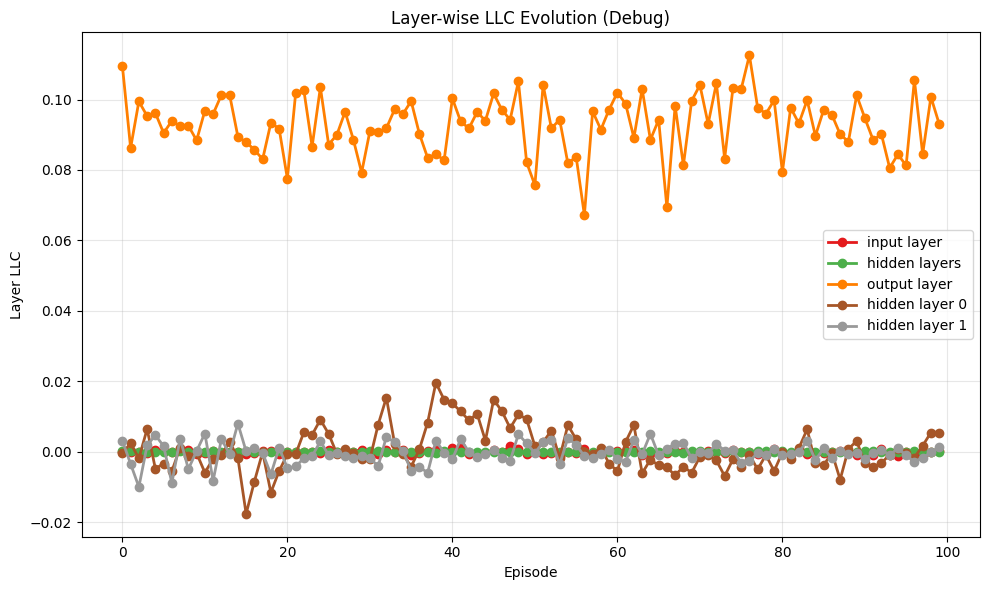

✅ Debug plot completed successfully!


In [28]:
def debug_plot_layer_evolution(enhanced_visualizer, figsize=(14, 10)):
    """Debug version of plot_layer_wise_evolution"""
    
    print("🔍 DEBUG: plot_layer_wise_evolution")
    print("-" * 40)
    
    try:
        layer_evolution = enhanced_visualizer.tracker.get_layer_wise_evolution()
        print(f"Layer evolution data: {layer_evolution is not None}")
        
        if not layer_evolution:
            print("❌ No layer evolution data - cannot plot")
            return
            
        episodes = layer_evolution.get("episodes", [])
        print(f"Episodes: {len(episodes)} items")
        
        if len(episodes) == 0:
            print("❌ No episodes data - cannot plot")
            return
        
        # Extract layer names
        layer_names = [key.replace('_llc_mean', '') for key in layer_evolution.keys() 
                      if key.endswith('_llc_mean')]
        print(f"Layer names: {layer_names}")
        
        if not layer_names:
            print("❌ No layer LLC data found - cannot plot")
            return
        
        print(f"✅ Data validation passed - creating plot...")
        
        # Create simple plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(layer_names)))
        
        for i, layer_name in enumerate(layer_names):
            llc_mean = layer_evolution[f'{layer_name}_llc_mean']
            print(f"  Plotting {layer_name}: {len(llc_mean)} values")
            
            # Only plot if there's significant data
            if any(abs(v) > 1e-6 for v in llc_mean):
                ax.plot(episodes, llc_mean, color=colors[i], 
                       marker='o', linewidth=2, label=layer_name.replace('_', ' '))
                print(f"    ✅ Plotted {layer_name}")
            else:
                print(f"    ⚠️ Skipped {layer_name} (no significant data)")
        
        ax.set_xlabel('Episode')
        ax.set_ylabel('Layer LLC')
        ax.set_title('Layer-wise LLC Evolution (Debug)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        print("📊 Showing plot...")
        plt.tight_layout()
        plt.show()
        plt.close(fig)
        
        print("✅ Debug plot completed successfully!")
        
    except Exception as e:
        import traceback
        print(f"❌ Error in debug plot: {e}")
        print("🔍 Full traceback:")
        traceback.print_exc()

# 実行
debug_plot_layer_evolution(enhanced_visualizer)

In [29]:
def create_enhanced_dashboard_with_real_data(enhanced_visualizer, figsize=(16, 12)):
    """Create enhanced dashboard using all available real data"""
    
    print("📊 Creating enhanced dashboard with real data...")
    
    tracker = enhanced_visualizer.tracker
    layer_evolution = tracker.get_layer_wise_evolution()
    
    if not layer_evolution:
        print("❌ No data available")
        return
    
    # Safe figure creation
    fig, axes = plt.subplots(2, 3, figsize=(min(figsize[0], 16), min(figsize[1], 12)))
    fig.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.88, wspace=0.3, hspace=0.4)
    fig.suptitle('Enhanced LLC Analysis Dashboard (Real Data)', fontsize=14, fontweight='bold')
    
    episodes = layer_evolution.get('episodes', [])
    
    # Plot 1: Main Layer LLC Evolution (already working)
    ax1 = axes[0, 0]
    main_layers = ['input_layer', 'hidden_layers', 'output_layer']
    colors = ['blue', 'green', 'red']
    
    for i, layer in enumerate(main_layers):
        if f'{layer}_llc_mean' in layer_evolution:
            llc_values = layer_evolution[f'{layer}_llc_mean']
            if any(abs(v) > 1e-6 for v in llc_values):
                ax1.plot(episodes, llc_values, color=colors[i], 
                       marker='o', linewidth=2, label=layer.replace('_', ' '))
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('LLC')
    ax1.set_title('Main Layer LLC Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Individual Hidden Layers
    ax2 = axes[0, 1]
    hidden_layer_keys = [k for k in layer_evolution.keys() if 'hidden_layer_' in k and 'llc_mean' in k]
    
    if hidden_layer_keys:
        for i, key in enumerate(hidden_layer_keys):
            values = layer_evolution[key]
            layer_name = key.replace('_llc_mean', '').replace('hidden_layer_', 'H')
            if any(abs(v) > 1e-6 for v in values):
                ax2.plot(episodes, values, marker='o', linewidth=2, label=layer_name)
        
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('LLC')
        ax2.set_title('Individual Hidden Layers')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No individual hidden\nlayer data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Individual Hidden Layers')
    
    # Plot 3: Parameter Count Distribution
    ax3 = axes[0, 2]
    param_keys = [k for k in layer_evolution.keys() if 'param_count' in k]
    
    if param_keys:
        layer_names = []
        param_counts = []
        
        for key in param_keys:
            if layer_evolution[key]:  # Check if data exists
                layer_name = key.replace('_param_count', '').replace('_', ' ').title()
                param_count = layer_evolution[key][0] if isinstance(layer_evolution[key], list) else layer_evolution[key]
                
                if param_count > 0:  # Only include layers with parameters
                    layer_names.append(layer_name)
                    param_counts.append(param_count)
        
        if layer_names and param_counts:
            wedges, texts, autotexts = ax3.pie(param_counts, labels=layer_names, 
                                              autopct='%1.1f%%', startangle=90)
            ax3.set_title('Parameter Distribution')
            
            # Make text smaller
            for text in texts:
                text.set_fontsize(8)
            for autotext in autotexts:
                autotext.set_fontsize(7)
        else:
            ax3.text(0.5, 0.5, 'No parameter\ncount data', 
                    ha='center', va='center', transform=ax3.transAxes)
    else:
        ax3.text(0.5, 0.5, 'No parameter\ncount data', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # Plot 4: LLC Standard Deviation
    ax4 = axes[1, 0]
    std_keys = [k for k in layer_evolution.keys() if 'llc_std' in k]
    
    if std_keys:
        for i, key in enumerate(std_keys[:3]):  # Show first 3
            values = layer_evolution[key]
            layer_name = key.replace('_llc_std', '').replace('_', ' ').title()
            if any(abs(v) > 1e-6 for v in values):
                ax4.plot(episodes, values, marker='s', linewidth=2, label=layer_name)
        
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('LLC Standard Deviation')
        ax4.set_title('LLC Uncertainty Over Time')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No standard deviation\ndata available', 
                ha='center', va='center', transform=ax4.transAxes)
    
    # Plot 5: Rewards Evolution
    ax5 = axes[1, 1]
    if 'rewards' in layer_evolution:
        rewards = layer_evolution['rewards']
        ax5.plot(episodes, rewards, 'purple', marker='D', linewidth=2, label='Rewards')
        ax5.set_xlabel('Episode')
        ax5.set_ylabel('Reward')
        ax5.set_title('Training Rewards')
        ax5.grid(True, alpha=0.3)
        
        # Add trend line
        if len(rewards) > 1:
            z = np.polyfit(episodes, rewards, 1)
            p = np.poly1d(z)
            ax5.plot(episodes, p(episodes), "r--", alpha=0.8, label=f'Trend: {z[0]:.4f}x + {z[1]:.4f}')
            ax5.legend()
    else:
        ax5.text(0.5, 0.5, 'No rewards\ndata available', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Training Rewards')
    
    # Plot 6: Data Summary Statistics
    ax6 = axes[1, 2]
    
    # Create summary statistics
    llc_keys = [k for k in layer_evolution.keys() if 'llc_mean' in k]
    
    if llc_keys:
        summary_data = []
        layer_labels = []
        
        for key in llc_keys:
            values = layer_evolution[key]
            if values and any(abs(v) > 1e-6 for v in values):
                layer_name = key.replace('_llc_mean', '').replace('_', ' ').title()
                mean_val = np.mean(values)
                summary_data.append(mean_val)
                layer_labels.append(layer_name)
        
        if summary_data:
            bars = ax6.bar(range(len(layer_labels)), summary_data, 
                          color=plt.cm.viridis(np.linspace(0, 1, len(layer_labels))))
            ax6.set_xticks(range(len(layer_labels)))
            ax6.set_xticklabels(layer_labels, rotation=45, ha='right', fontsize=8)
            ax6.set_ylabel('Mean LLC')
            ax6.set_title('Average LLC by Layer')
            
            # Add value labels on bars
            for bar, val in zip(bars, summary_data):
                ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(summary_data)*0.01,
                        f'{val:.4f}', ha='center', va='bottom', fontsize=8)
        else:
            ax6.text(0.5, 0.5, 'No significant\nLLC data', 
                    ha='center', va='center', transform=ax6.transAxes)
    else:
        ax6.text(0.5, 0.5, 'No LLC data\navailable', 
                ha='center', va='center', transform=ax6.transAxes)
    
    ax6.set_title('LLC Summary Statistics')
    
    plt.show()
    plt.close(fig)
    
    print("✅ Enhanced dashboard created successfully!")

In [30]:
def print_data_summary(enhanced_visualizer):
    """Print comprehensive data summary"""
    
    print("📋 COMPREHENSIVE DATA SUMMARY")
    print("=" * 60)
    
    layer_evolution = enhanced_visualizer.tracker.get_layer_wise_evolution()
    
    if layer_evolution:
        episodes = layer_evolution.get('episodes', [])
        print(f"📊 Dataset Overview:")
        print(f"  • Episodes: {len(episodes)} (range: {min(episodes)}-{max(episodes)})")
        
        # LLC analysis
        llc_keys = [k for k in layer_evolution.keys() if 'llc_mean' in k]
        print(f"  • LLC measurements: {len(llc_keys)} layers")
        
        print(f"\n🎯 Layer-wise LLC Analysis:")
        for key in llc_keys:
            values = layer_evolution[key]
            layer_name = key.replace('_llc_mean', '').replace('_', ' ').title()
            
            if values:
                mean_val = np.mean(values)
                min_val = np.min(values)
                max_val = np.max(values)
                std_val = np.std(values)
                negative_count = sum(1 for v in values if v < 0)
                
                print(f"  • {layer_name:<20}: μ={mean_val:.6f}, σ={std_val:.6f}")
                print(f"    └─ Range: [{min_val:.6f}, {max_val:.6f}]")
                print(f"    └─ Negative values: {negative_count}/{len(values)}")
                
                # Parameter count
                param_key = key.replace('_llc_mean', '_param_count')
                if param_key in layer_evolution and layer_evolution[param_key]:
                    param_count = layer_evolution[param_key][0]
                    print(f"    └─ Parameters: {param_count:,}")
        
        # Rewards analysis
        if 'rewards' in layer_evolution:
            rewards = layer_evolution['rewards']
            print(f"\n🏆 Rewards Analysis:")
            print(f"  • Mean reward: {np.mean(rewards):.6f}")
            print(f"  • Final reward: {rewards[-1]:.6f}")
            print(f"  • Improvement: {rewards[-1] - rewards[0]:.6f}")
    
    print("=" * 60)


📋 Creating layer-wise analysis summary...


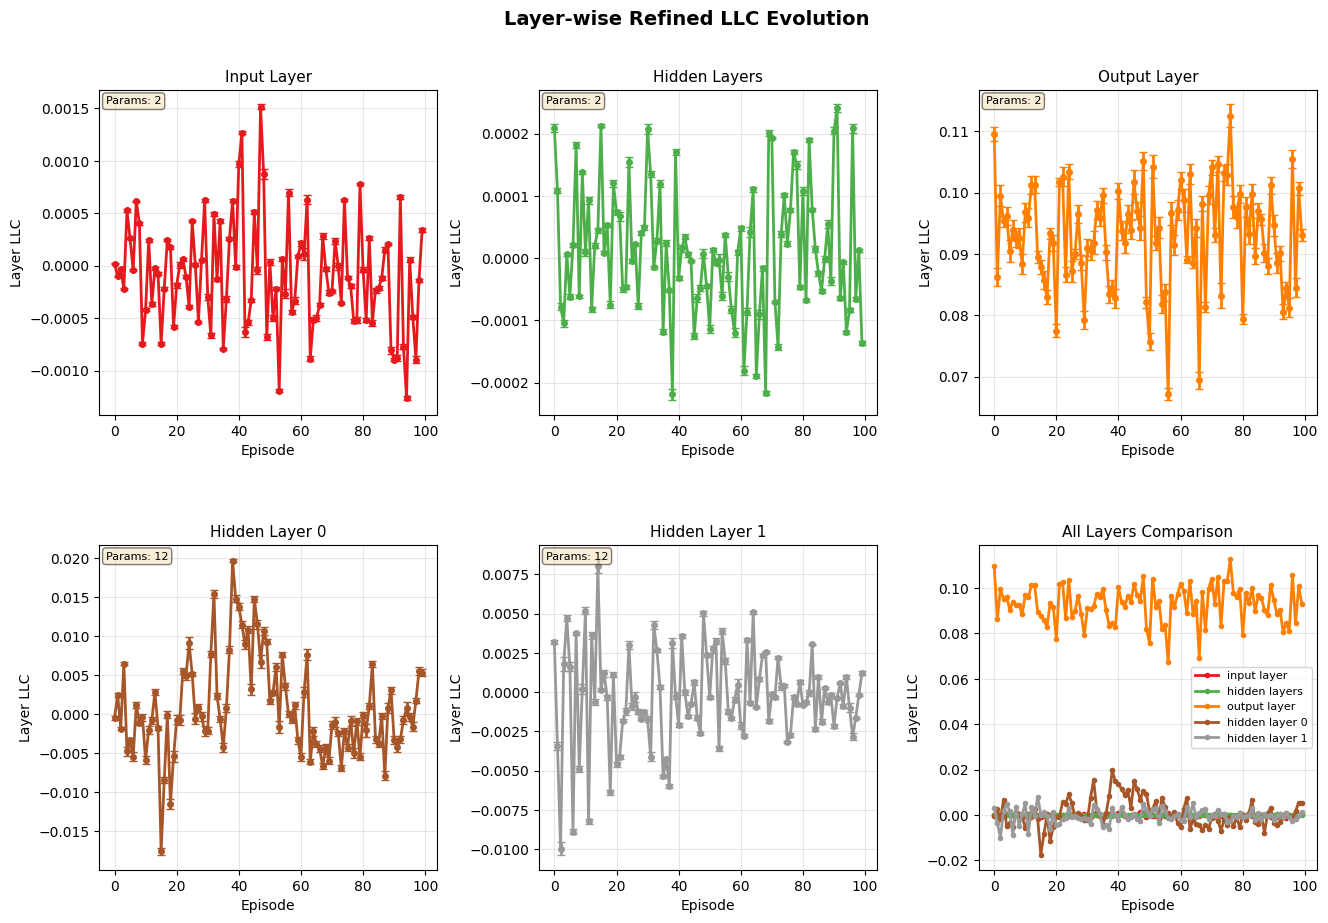

📊 Creating enhanced dashboard with real data...


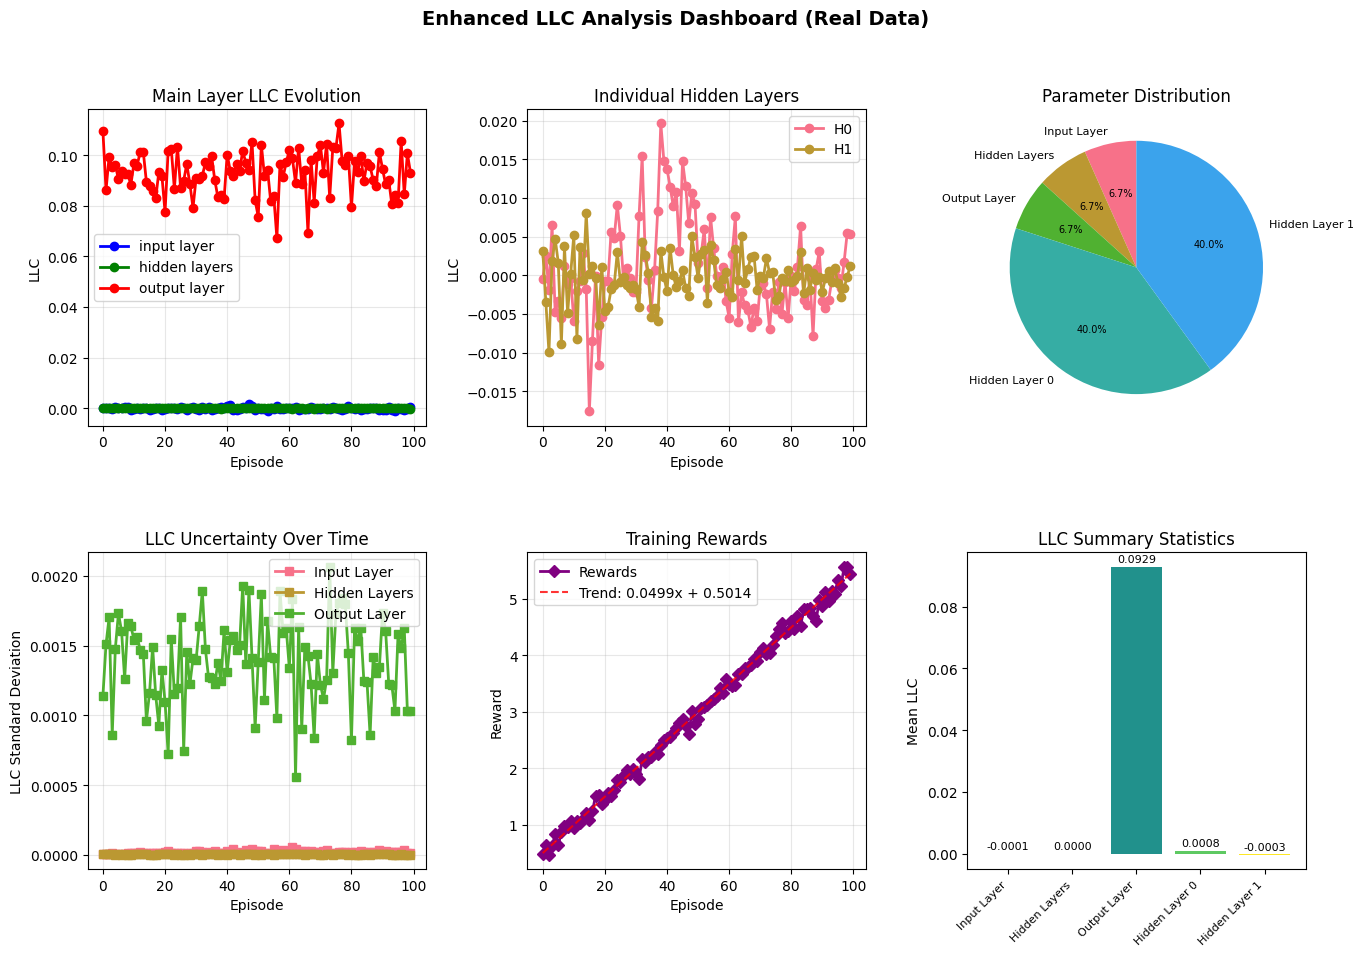

✅ Enhanced dashboard created successfully!
📋 COMPREHENSIVE DATA SUMMARY
📊 Dataset Overview:
  • Episodes: 100 (range: 0-99)
  • LLC measurements: 5 layers

🎯 Layer-wise LLC Analysis:
  • Input Layer         : μ=-0.000085, σ=0.000508
    └─ Range: [-0.001262, 0.001515]
    └─ Negative values: 60/100
    └─ Parameters: 2
  • Hidden Layers       : μ=0.000012, σ=0.000103
    └─ Range: [-0.000219, 0.000241]
    └─ Negative values: 47/100
    └─ Parameters: 2
  • Output Layer        : μ=0.092894, σ=0.008249
    └─ Range: [0.067194, 0.112567]
    └─ Negative values: 0/100
    └─ Parameters: 2
  • Hidden Layer 0      : μ=0.000772, σ=0.006109
    └─ Range: [-0.017598, 0.019626]
    └─ Negative values: 58/100
    └─ Parameters: 12
  • Hidden Layer 1      : μ=-0.000323, σ=0.003027
    └─ Range: [-0.009971, 0.008030]
    └─ Negative values: 59/100
    └─ Parameters: 12

🏆 Rewards Analysis:
  • Mean reward: 2.973537
  • Final reward: 5.435284
  • Improvement: 4.952724
                    LAYER-WISE

In [31]:
# Create layer-wise summary
print("📋 Creating layer-wise analysis summary...")
enhanced_visualizer.plot_layer_wise_evolution(figsize=(14, 10))
create_enhanced_dashboard_with_real_data(enhanced_visualizer, figsize=(14, 10))
print_data_summary(enhanced_visualizer)
enhanced_visualizer.create_layer_summary()